#### 1

#### 2

#### 3

#### 4

#### Introduction

In [1]:
#Asset pricing anomalies are the foundations of factor investing



The core aim of factor models is to understand the drivers of asset prices. Broadly speaking, the rationale behind factor investing is that the financial performance of firms depends on factors, whether they be latent and unobservable, or related to intrinsic characteristics (like accounting ratios for instance). Indeed, as Cochrane (2011) frames it, the first essential question is which characteristics really provide independent information about average returns? Answering this question helps understand the cross-section of returns and may open the door to their prediction.

Theoretically, linear factor models can be viewed as special cases of the arbitrage pricing theory (APT) of Ross (1976), which assumes that the return of an asset n
can be modelled as a linear combination of underlying factors fk:

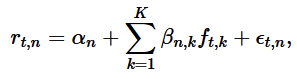


where the usual econometric constraints on linear models hold: E[ϵt,n]=0, cov(ϵt,n,ϵt,m)=0 for n≠m and cov(fn,ϵn)=0. If such factors do exist, then they are in contradiction with the cornerstone model in asset pricing: the capital asset pricing model (CAPM) of Sharpe (1964), Lintner (1965) and Mossin (1966). Indeed, according to the CAPM, the only driver of returns is the market portfolio. This explains why factors are also called ‘anomalies’.

Empirical evidence of asset pricing anomalies has accumulated since the dual publication of Fama and French (1992) and Fama and French (1993). This seminal work has paved the way for a blossoming stream of literature that has its meta-studies (e.g., Green, Hand, and Zhang (2013), Harvey, Liu, and Zhu (2016) and McLean and Pontiff (2016)). The regression (3.1) can be evaluated once (unconditionally) or sequentially over different time frames. In the latter case, the parameters (coefficient estimates) change and the models are thus called conditional (we refer to Ang and Kristensen (2012) and to Cooper and Maio (2019) for recent results on this topic as well as for a detailed review on the related research). Conditional models are more flexible because they acknowledge that the drivers of asset prices may not be constant, which seems like a reasonable postulate.

In [2]:
#Source: http://www.mlfactor.com/python.html
# Data Description: http://www.mlfactor.com/data-description.html

#https://www.mlfactor.com/

In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 1000)

In [4]:
import pyreadr

result = pyreadr.read_r('data_ml.RData') # also works for Rds


# result is a dictionary where keys are the name of objects and the values python
# objects
print(result.keys()) # let's check what objects we got
data_raw = result["data_ml"] # extract the pandas data frame for object df1


odict_keys(['data_ml'])


In [7]:
data_raw.date = [pd.to_datetime(i) for i in data_raw.date]

This dataset comprises information on 1,207 stocks listed in the US (possibly originating from Canada or Mexico). The time range starts in November 1998 and ends in March 2019. For each point in time, 93 characteristics describe the firms in the sample. These attributes cover a wide range of topics:

    valuation (earning yields, accounting ratios);
    profitability and quality (return on equity);
    momentum and technical analysis (past returns, relative strength index);
    risk (volatilities);
    estimates (earnings-per-share);
    volume and liquidity (share turnover).

The sample is not perfectly rectangular: there are no missing points, but the number of firms and their attributes is not constant through time. This makes the computations

in the backtest more tricky, but also more realistic.


In [8]:
idx_date=data_raw.index[(data_raw['date'] > pd.to_datetime('1999-12-31')) & (data_raw['date'] < (pd.to_datetime('2019-01-01')))].tolist() # creating and index to retrive the dates
data_ml=data_raw.iloc[idx_date]           # filtering the dataset according to date index
data_ml.iloc[1:6,1:6]

,date,Advt_12M_Usd,Advt_3M_Usd,Advt_6M_Usd,Asset_Turnover
1,2007-01-31,0.25,0.32,0.28,0.22
2,2007-02-28,0.26,0.30,0.30,0.22
3,2015-03-31,0.73,0.64,0.70,0.40
4,2015-04-30,0.72,0.62,0.66,0.40
5,2015-05-31,0.71,0.63,0.64,0.40


The data has 99 columns and 268336 rows. The first two columns indicate the stock identifier and the date. The next 93 columns are the features (see Table 17.1 in the Appendix for details). The last four columns are the labels. The points are sampled at the monthly frequency. As is always the case in practice, the number of assets changes with time, as is shown in Figure 1.1.

Text(0, 0.5, 'nb_assets')

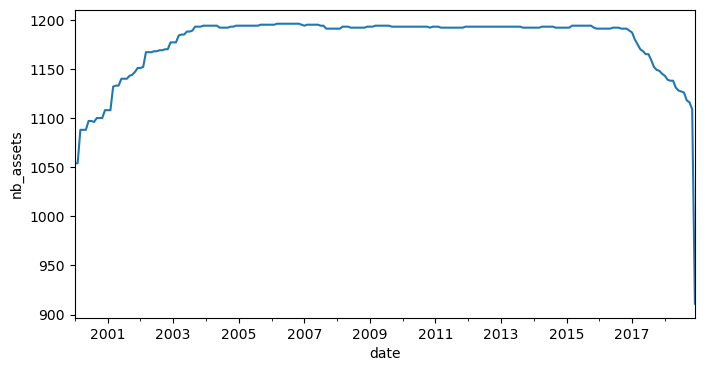

In [9]:
import matplotlib.pyplot as plt
pd.Series(data_ml.groupby('date').size()).plot(figsize=(8,4)) # counting the number of assets for each date
plt.ylabel('nb_assets') 

There are four immediate labels in the dataset: R1M_Usd, R3M_Usd, R6M_Usd and R12M_Usd, which correspond to the 1-month, 3-month, 6-month and 12-month future/forward returns of the stocks. The returns are total returns, that is, they incorporate potential dividend payments over the considered periods. This is a better proxy of financial gain compared to price returns only. We refer to the analysis of Hartzmark and Solomon (2019) for a study on the impact of decoupling price returns and dividends. These labels are located in the last 4 columns of the dataset. We provide their descriptive statistics below.

In [ ]:


## # A tibble: 4 x 5
##   Label      mean    sd    min   max
##   <chr>     <dbl> <dbl>  <dbl> <dbl>
## 1 R12M_Usd 0.137  0.738 -0.991  96.0
## 2 R1M_Usd  0.0127 0.176 -0.922  30.2
## 3 R3M_Usd  0.0369 0.328 -0.929  39.4
## 4 R6M_Usd  0.0723 0.527 -0.98  107.



In anticipation for future models, we keep the name of the predictors in memory. In addition, we also keep a much shorter list of predictors.

In [10]:
features=list(data_ml.iloc[:,3:95].columns) # Keep the feature's column names (hard-coded, beware!)
features_short =["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", 
                    "Ocf", "Pb", "Vol1Y_Usd"]


The predictors have been uniformized, that is, for any given feature and time point, the distribution is uniform. Given 1,207 stocks, the graph below cannot display a perfect rectangle.

Text(0, 0.5, 'count')

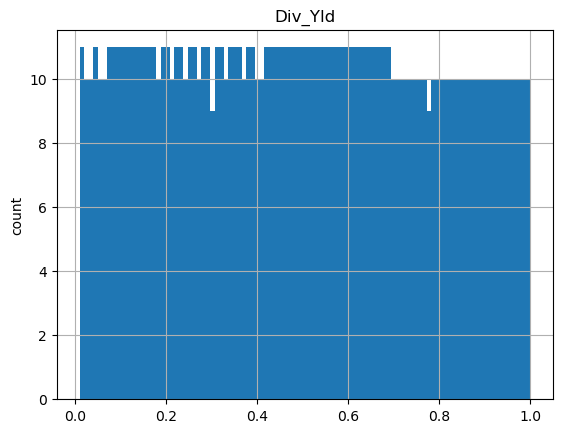

In [11]:
col_feat_Div_Yld=data_ml.columns.get_loc('Div_Yld') # finding the location of the column/feature Div_Yld
is_custom_date = data_ml['date']=='2000-02-29'       # creating a boolean index to filter on 
data_ml[is_custom_date].iloc[:,[col_feat_Div_Yld]].hist(bins=100) # using the hist , see uniform distribution of spread of Dividend Yield
plt.ylabel('count')

The original labels (future returns) are numerical and will be used for regression exercises, that is, when the objective is to predict a scalar real number. Sometimes, the exercises can be different and the purpose may be to forecast categories (also called classes), like “buy”, “hold” or “sell”. In order to be able to perform this type of classification analysis, we create additional labels that are categorical.

In [12]:
df_median=[]          #creating empty placeholder for temporary dataframe
df=[]                #creating empty placeholder for temporary dataframe
df_median=data_ml[['date','R1M_Usd','R12M_Usd']].groupby(['date']).median() # computings medians for both labels at each date 
df_median.rename(columns={"R1M_Usd": "R1M_Usd_median", "R12M_Usd": "R12M_Usd_median"},inplace=True)
df = pd.merge(data_ml,df_median,how='left', on=['date'])             # join the dataframes
data_ml['R1M_Usd_C'] = np.where(df['R1M_Usd'] > df['R1M_Usd_median'], 1.0, 0.0) # Create the categorical labels
data_ml['R12M_Usd_C'] = np.where(df['R12M_Usd'] > df['R12M_Usd_median'], 1.0, 0.0) # Create the categorical labels
df_median=[]          #removing the temp dataframe to keep it light!
df=[]                 #removing the temp dataframe to keep it light!

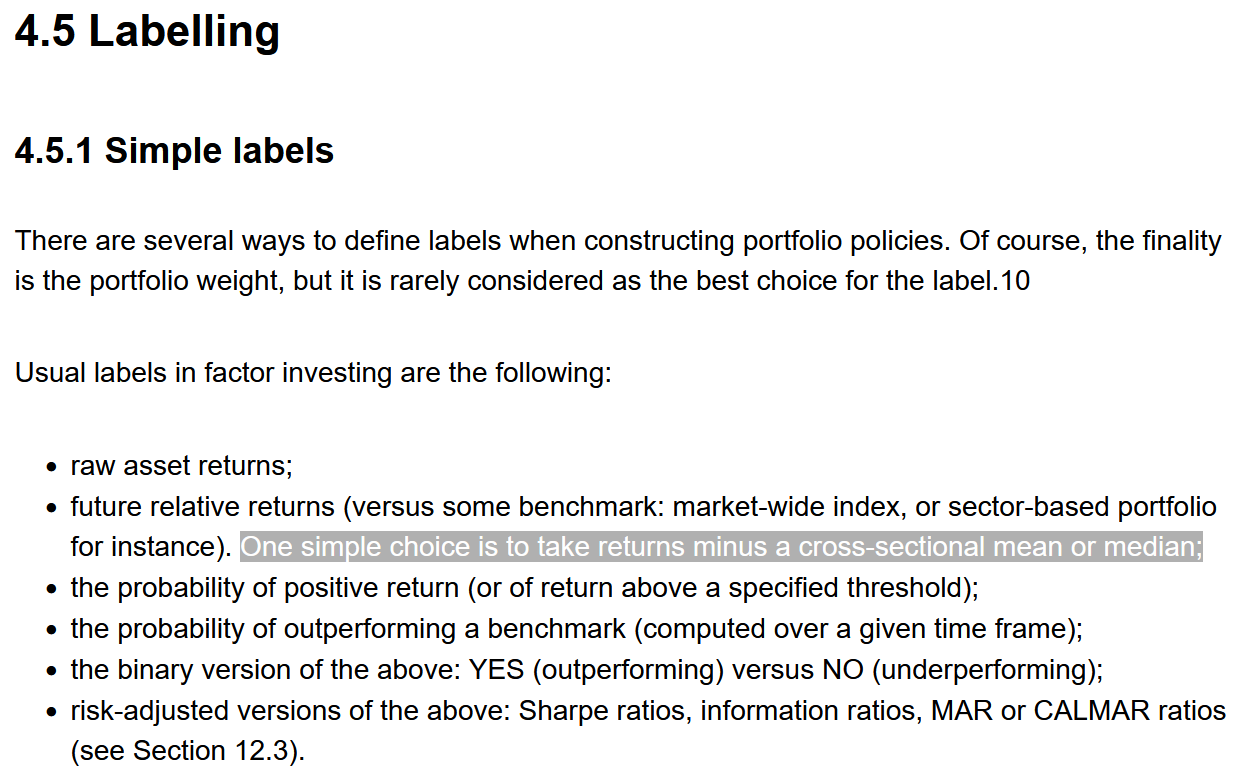
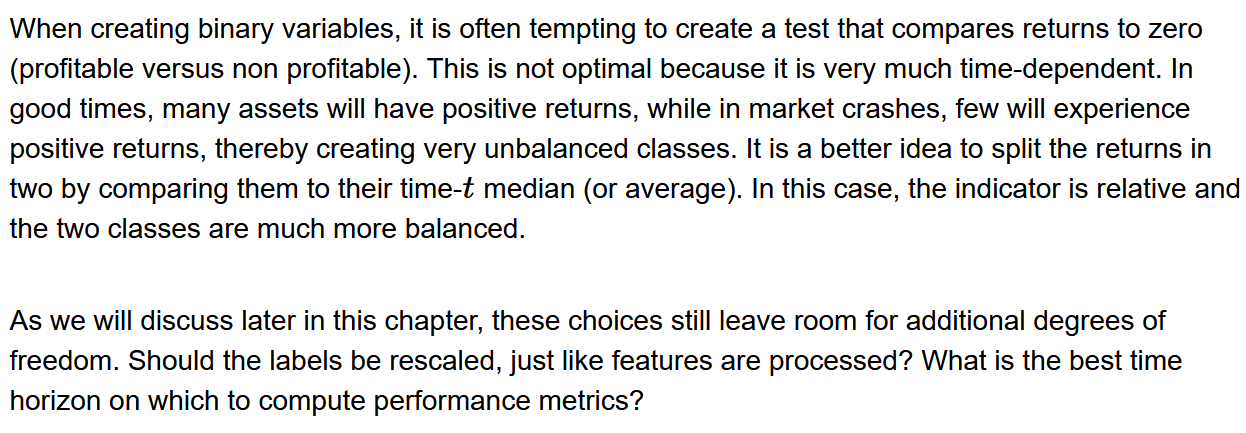

The new labels are binary: they are equal to 1 (true) if the original return is above that of the median return over the considered period and to 0 (false) if not. Hence, at each point in time, half of the sample has a label equal to zero and the other half to one: some stocks overperform and others underperform.

In machine learning, models are estimated on one portion of data (training set) and then tested on another portion of the data (testing set) to assess their quality. We split our sample accordingly.

In [13]:
separation_date = "2014-01-15"
idx_train=data_ml.index[(data_ml['date'] < separation_date)].tolist() 
idx_test=data_ml.index[(data_ml['date'] >= separation_date)].tolist() 


We also keep in memory a few key variables, like the list of asset identifiers and a rectangular version of returns. For simplicity, in the computation of the latter, we shrink the investment universe to keep only the stocks for which we have the maximum number of points.

In [68]:
stock_ids_short=[]   # creating empty placeholder for temporary dataframe
stock_days=[]        # creating empty placeholder for temporary dataframe
stock_ids=data_ml['stock_id'].unique() # A list of all stock_ids
stock_days=data_ml[['date','stock_id']].groupby(['stock_id']).count().reset_index() # compute the number of data points per stock
stock_ids_short=stock_days.loc[stock_days['date'] == (stock_days['date'].max())] # Stocks with full data
stock_ids_short=stock_ids_short['stock_id'].unique() ### in order to get a list 
is_stock_ids_short = data_ml['stock_id'].isin(stock_ids_short) 

returns = data_ml[is_stock_ids_short].pivot(index='date',columns='stock_id',values='R1M_Usd') # compute returns in matrix format

In [69]:
returns

stock_id,1,3,4,7,9,11,12,16,17,18,...,1199,1200,1201,1202,1203,1204,1208,1209,1210,1212
date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,-0.036,0.077,-0.016,-0.009,0.032,0.144,-0.110,-0.191,-0.103,0.098,...,-0.509,0.039,-0.011,-0.019,0.168,0.080,-0.372,-0.560,-0.006,-0.186
2000-02-29,0.263,-0.024,0.000,0.027,0.076,0.258,0.110,0.197,-0.053,-0.001,...,-0.147,0.017,-0.148,0.118,0.177,0.161,0.143,-0.102,-0.057,0.104
2000-03-31,0.031,0.018,0.153,0.000,-0.025,0.049,0.134,-0.030,0.074,-0.002,...,0.083,0.006,-0.025,-0.009,0.237,-0.008,0.057,0.144,0.085,-0.143
2000-04-30,0.448,0.027,-0.011,-0.017,-0.022,0.014,0.022,0.161,0.051,-0.037,...,-0.192,0.003,-0.061,0.053,-0.097,-0.114,0.070,-0.103,0.073,0.204
2000-05-31,-0.097,0.050,0.014,0.018,-0.121,-0.116,-0.038,-0.020,0.038,-0.131,...,-0.279,0.014,0.118,0.089,-0.023,-0.089,-0.137,0.113,0.016,0.042
2000-06-30,-0.157,0.008,0.048,0.061,-0.030,0.073,-0.075,0.134,-0.039,0.050,...,0.065,0.029,-0.012,-0.016,0.363,0.123,-0.071,0.155,0.063,0.204
2000-07-31,0.291,-0.020,-0.005,-0.041,0.072,0.193,0.203,0.029,0.028,-0.038,...,-0.152,0.088,0.089,-0.074,0.116,-0.041,-0.055,0.049,0.039,0.006
2000-08-31,0.037,0.056,0.020,-0.016,0.017,-0.081,0.134,-0.022,-0.054,0.119,...,-0.276,0.013,-0.006,0.083,0.121,-0.118,-0.193,0.116,0.040,0.170
2000-09-30,-0.079,-0.039,0.044,-0.009,-0.006,-0.154,-0.023,-0.046,-0.098,0.071,...,-0.143,0.012,0.006,-0.055,-0.068,0.135,-0.146,0.007,-0.037,-0.109


In the code and Figure below, we compute size portfolios (equally weighted: above versus below the median capitalization). According to the size anomaly, the firms with below median market cap should earn higher returns on average. This is verified whenever the orange bar in the plot is above the blue one (it happens most of the time).

In [14]:
############################################## this is the size factor ###########################################

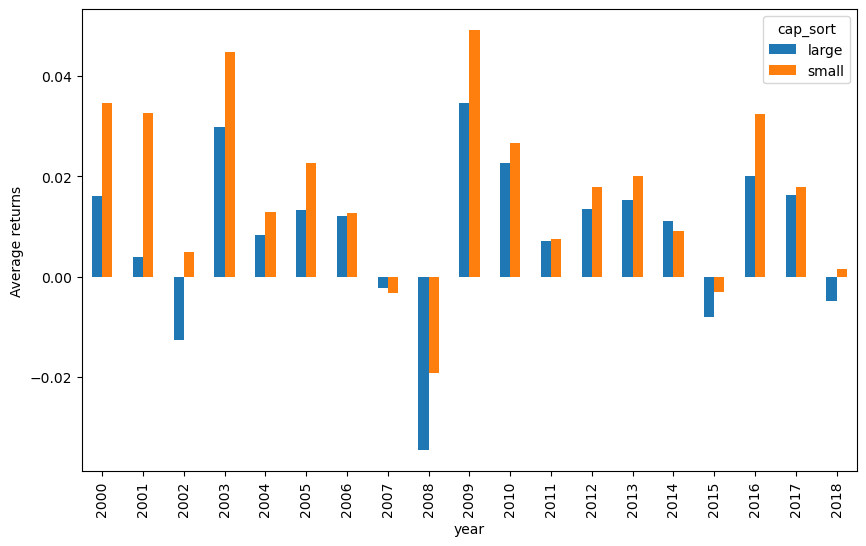

In [16]:
df_median=[]          #creating empty placeholder for temporary dataframe
df=[]       
df_median=data_ml[['date','Mkt_Cap_12M_Usd']].groupby(['date']).median().reset_index() # computing median
df_median.rename(columns = {'Mkt_Cap_12M_Usd': 'cap_median'}, inplace = True) # renaming for clarity
df = pd.merge(data_ml[["date",'Mkt_Cap_12M_Usd','R1M_Usd']],df_median,how='left', on=['date']) 
df=df.groupby([pd.to_datetime(df['date']).dt.year,np.where(df['Mkt_Cap_12M_Usd'] > df['cap_median'], 'large', 'small')])['R1M_Usd'].mean().reset_index() # groupby and defining "year" and cap logic
df.rename(columns = {'level_1': 'cap_sort'}, inplace = True) 
df.pivot(index='date',columns='cap_sort',values='R1M_Usd').plot.bar(figsize=(10,6))
plt.ylabel('Average returns')
plt.xlabel('year')    
df_median=[]          #removing the temp dataframe to keep it light!
df=[]                 #removing the temp dataframe to keep it light!

#### Factors

The construction of so-called factors follows the same lines as above. Portfolios are based on one characteristic and the factor is a long-short ensemble of one extreme portfolio minus the opposite extreme (small minus large for the size factor or high book-to-market ratio minus low book-to-market ratio for the value factor). Sometimes, subtleties include forming bivariate sorts and aggregating several portfolios together, as in the original contribution of Fama and French (1993). The most common factors are listed below, along with a few references. We refer to the books listed at the beginning of the chapter for a more exhaustive treatment of factor idiosyncrasies. For most anomalies, theoretical justifications have been brought forward, whether risk-based or behavioral. We list the most frequently cited factors below:

In [20]:
# Below, we import data from Ken French’s data library. We will use it later on in the chapter.

In [45]:
# import urllib.request

# min_date = '1963-07-31'
# max_date = '2020-03-28'
# ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip" # Create the download url 
# urllib.request.urlretrieve(ff_url,'factors.zip') # Download it and rename it



In [46]:
########################################### TABLE: Sample of monthly factor returns ############################################

In [19]:
min_date = '1963-07-31'
max_date = '2020-03-28'

from pandas.tseries.offsets import MonthEnd

df_ff = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv', header=2, sep=',', quotechar='"')
df_ff.rename(columns = {'Mkt-RF':'MKT_RF'}, inplace = True) # renaming for clarity
df_ff = df_ff.iloc[:736,:].apply(pd.to_numeric)

df_ff[['MKT_RF','SMB','HML','RMW','CMA','RF']]=df_ff[['MKT_RF','SMB','HML','RMW','CMA','RF']]/100.0 # Scale returns
df_ff.rename(columns = {'Unnamed: 0':'date'}, inplace = True)
df_ff['date'] = df_ff['date'].astype(str)

df_ff['date'] = pd.to_datetime(df_ff['date'], format="%Y%m") + MonthEnd(0)
df_ff['year']= df_ff['date'].dt.year

idx_ff=df_ff.index[(df_ff['date'] >= min_date) & (df_ff['date'] <= max_date)].tolist()
FF_factors=df_ff.iloc[idx_ff]
# FF_factors=FF_factors.drop(columns=['date_int'])
FF_factors.iloc[1:6,1:7].head()


,MKT_RF,SMB,HML,RMW,CMA,RF
1,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0025
2,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0027
3,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0029
4,-0.0085,-0.0088,0.0175,-0.0051,0.0224,0.0027
5,0.0183,-0.0210,-0.0002,0.0003,-0.0007,0.0029


In [48]:
# https://blogs.cfainstitute.org/investor/2022/01/10/fama-and-french-the-five-factor-model-revisited/
# https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library/f-f_5_factors_2x3.html

# Fama/French 5 Research Factors
# Rm-Rf :the excess return on the market
# SMB : small minus big (SMB), which represents the return spread between small- and large-cap stocks,: so basically you go long on small stock portfolio and short on large stock portfolio
# HML : high minus low (HML), which measures the return spread between high book-to-market and low book-to-market stocks. 
# RMW : robust minus weak (RMW), which compares the returns of firms with high, or robust, operating profitability, and those with weak, or low, operating profitability
# CMA : conservative minus aggressive (CMA), which gauges the difference between companies that invest aggressively and those that do so more conservatively.

Rm-Rf, the excess return on the market, value-weight return of all CRSP firms incorporated in the US and listed on the NYSE, AMEX, or NASDAQ that have a CRSP share code of 10 or 11 at the beginning of month t, good shares and price data at the beginning of t, and good return data for t minus the one-month Treasury bill rate. The one-month Treasury bill rate data through May 2024 are from Ibbotson Associates. Starting from October 2024, the one-month Treasury bill rate is from ICE BofA US 1-Month Treasury Bill Index.

In Figure, we plot the average monthly return aggregated over each calendar year for five common factors. The risk free rate (which is not a factor per se) is the most stable, while the market factor (aggregate market returns minus the risk-free rate) is the most volatile. This makes sense because it is the only long equity factor among the five series.

In [19]:
################################# Average returns of common anomalies or factors (1963-2020). Source: Ken French library ##################

Text(0.5, 0, 'date')

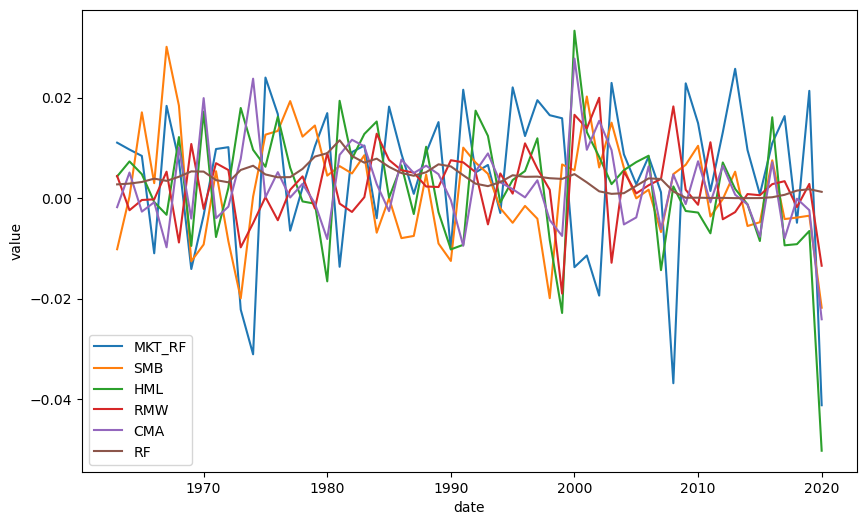

In [18]:
FF_factors.drop(columns = 'date', inplace=True)
FF_factors.groupby(FF_factors['year']).mean().plot(figsize=(10,6)) # groupby and defining "year" and cap logic
plt.ylabel('value')
plt.xlabel('date')

#### Chapter 3: Fama and MacBeth (1973) regressions

Below, we perform Fama and MacBeth (1973) regressions on our sample. We start by the first pass: individual estimation of betas. We build a dedicated function below to automate the process

Another detection method was proposed by Fama and MacBeth (1973) through a two-stage regression analysis of risk premia. The first stage is a simple estimation of the relationship (): the regressions are run on a stock-by-stock basis over the corresponding time series.

In [20]:
import statsmodels.api as sm

data_FM = pd.merge(returns.iloc[:,0].reset_index(),FF_factors.iloc[:,0:7],how='left', on=['date'])
data = FF_factors
data_FM.dropna(inplace=True)
stocks_list = list(returns.columns)

results_params = []
reg_result=[]
df_res_full=[]
df_res_full1=[]
for i in range(len(returns.columns)):
    Y = returns.iloc[:,i].shift(-1).reset_index()  #trying to predict 1 month ahead returns. So for Jan'24 we want to predict Feb returns
    Y = Y.drop(columns=['date'])                   #So basically using Jan'24 factor values we are trying to predict Feb'24 returns of each stock
    
    Y.dropna(inplace=True)
    results=sm.OLS(endog=Y,exog=sm.add_constant(data_FM.iloc[0:227,2:7])).fit() 
    
    results_params=results.params
    reg_result=pd.DataFrame(results_params)    
    reg_result['stock_id']= stocks_list[i]
    
    reg_result1 = reg_result.copy()
    reg_result1.loc['R_sq',0] = results.rsquared 
    reg_result1.loc['R_sq','stock_id'] = stocks_list[i]
    
    df_res_full.append(reg_result)
    df_res_full1.append(reg_result1)

df_res_full = pd.concat(df_res_full)
df_res_full1 = pd.concat(df_res_full1)

df_res_full.reset_index(inplace=True)
df_res_full.rename(columns={"index": "factors_name", 0: "betas"},inplace=True)
df_res_full_mat = df_res_full.pivot(index='stock_id',columns='factors_name',values='betas')
column_names_inverted = ["const", "MKT_RF", "SMB","HML","RMW","CMA"]
reg_result = df_res_full_mat.reindex(columns=column_names_inverted)



df_res_full1.reset_index(inplace=True)
df_res_full1.rename(columns={"index": "factors_name", 0: "betas + R_sq"},inplace=True)
df_res_full_mat1 = df_res_full1.pivot(index='stock_id',columns='factors_name',values='betas + R_sq')
column_names_inverted = ["const", "MKT_RF", "SMB","HML","RMW","CMA", 'R_sq']
reg_result1 = df_res_full_mat1.reindex(columns=column_names_inverted)

In [21]:
reg_result1.head()


factors_name,const,MKT_RF,SMB,HML,RMW,CMA,R_sq
stock_id,,,,,,,
1.0,0.017385,0.135925,0.088914,-0.394731,0.508615,0.478881,0.012633
3.0,0.009403,-0.234715,-0.121142,0.088811,-0.205260,-0.344264,0.012579
4.0,0.011793,-0.005960,-0.047208,0.013282,-0.310708,-0.034570,0.031461
7.0,0.014240,-0.338030,-0.019414,-0.018568,-0.261689,0.240674,0.050413
9.0,0.013180,-0.203108,0.266002,0.173311,-0.170657,0.022076,0.016430


In the table, MKT_RF is the market return minus the risk free rate. The corresponding coefficient is often referred to as the beta, especially in univariate regressions.

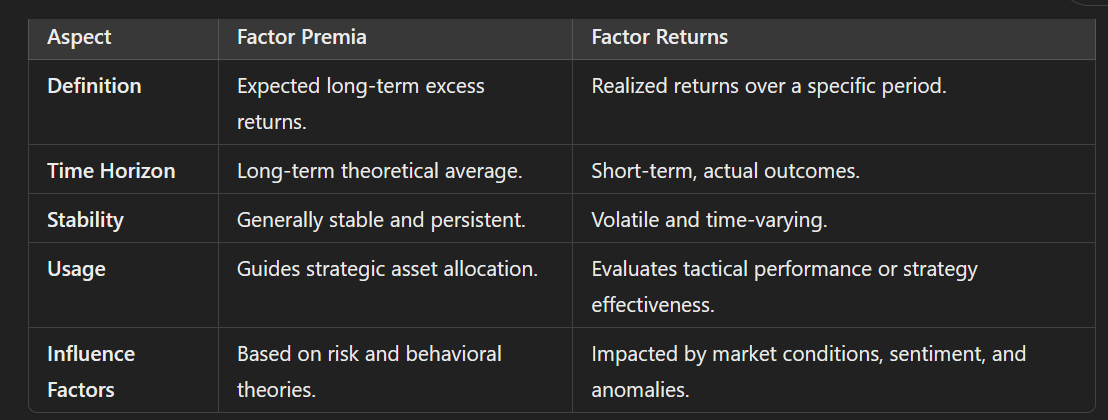

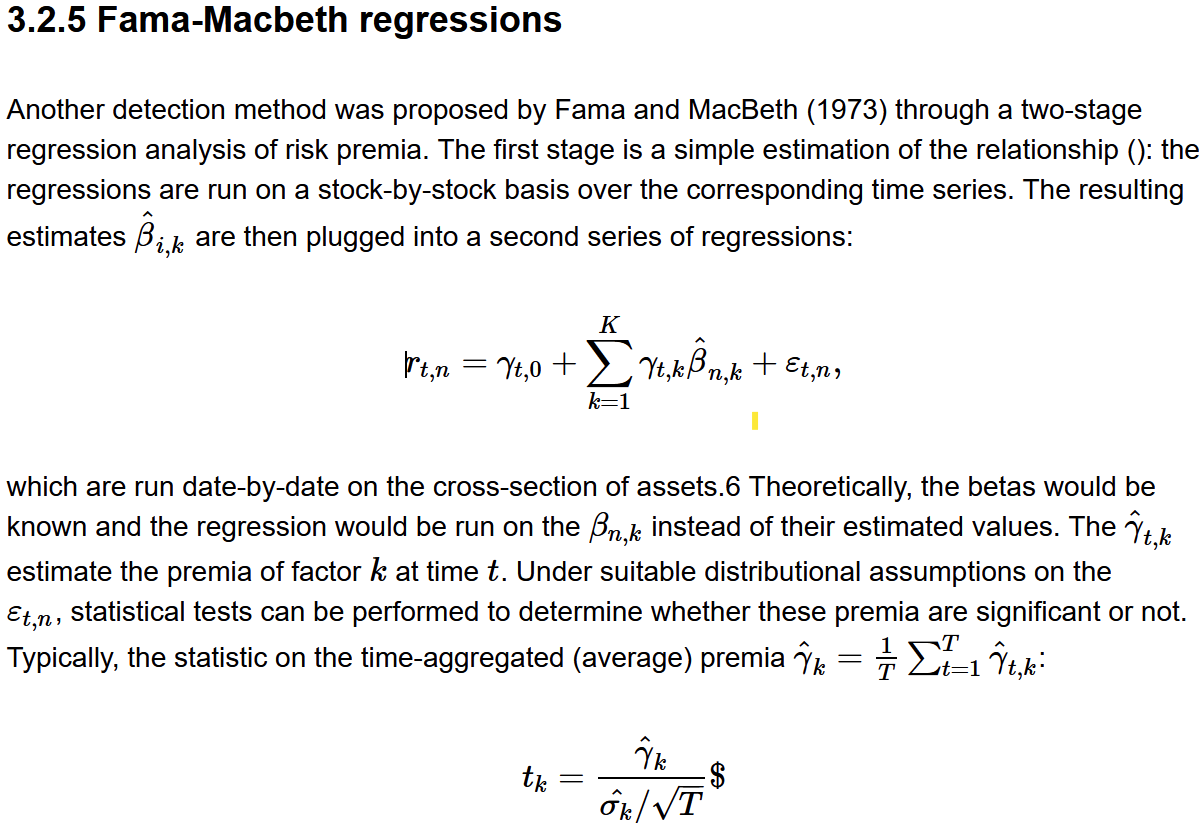

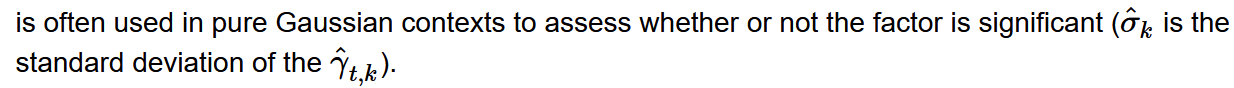

We then reformat these betas from Table 3.2 to prepare the second pass. Each line corresponds to one asset: the first 5 columns are the estimated factor loadings and the remaining ones are the asset returns (date by date).

In [22]:
returns_trsp=returns.transpose()
df_2nd_pass=pd.concat([reg_result.iloc[:,1:6], returns.transpose()], axis=1)
df_2nd_pass.head()

,MKT_RF,SMB,HML,RMW,CMA,2000-01-31 00:00:00,2000-02-29 00:00:00,2000-03-31 00:00:00,2000-04-30 00:00:00,2000-05-31 00:00:00,...,2018-03-31 00:00:00,2018-04-30 00:00:00,2018-05-31 00:00:00,2018-06-30 00:00:00,2018-07-31 00:00:00,2018-08-31 00:00:00,2018-09-30 00:00:00,2018-10-31 00:00:00,2018-11-30 00:00:00,2018-12-31 00:00:00
stock_id,,,,,,,,,,,,,,,,,,,,,
1,0.135925,0.088914,-0.394731,0.508615,0.478881,-0.036,0.263,0.031,0.448,-0.097,...,0.173,-0.042,-0.038,0.000,-0.077,-0.002,-0.155,0.014,-0.110,0.082
3,-0.234715,-0.121142,0.088811,-0.205260,-0.344264,0.077,-0.024,0.018,0.027,0.050,...,-0.039,0.030,-0.028,-0.039,0.033,-0.049,-0.070,0.036,-0.070,0.030
4,-0.005960,-0.047208,0.013282,-0.310708,-0.034570,-0.016,0.000,0.153,-0.011,0.014,...,0.071,-0.024,0.059,0.029,-0.004,0.036,-0.025,0.000,-0.088,0.043
7,-0.338030,-0.019414,-0.018568,-0.261689,0.240674,-0.009,0.027,0.000,-0.017,0.018,...,0.030,0.100,0.036,-0.005,0.022,-0.068,-0.052,0.007,-0.066,0.131
9,-0.203108,0.266002,0.173311,-0.170657,0.022076,0.032,0.076,-0.025,-0.022,-0.121,...,0.046,0.047,0.000,0.064,-0.137,-0.028,-0.098,-0.018,-0.099,0.112


In [23]:
returns_trsp = returns.transpose()
df_2nd_pass = pd.concat([reg_result.iloc[:,1:6], returns.transpose()], axis=1)
betas = df_2nd_pass.iloc[:,0:5]
date_list = list(returns_trsp.columns)

results_params = []
reg_result = []
df_res_full = []

for j in range(len(returns_trsp.columns)):
    
    Y = returns_trsp.iloc[:,j] # vector of returns on jth date for all stocks
    results = sm.OLS(endog=Y,exog=sm.add_constant(betas)).fit()
    
    results_params = results.params
    reg_result_tmp = pd.DataFrame(results_params)
    reg_result_tmp['date']= date_list[j]
    
    reg_result_tmp1 = reg_result_tmp.copy()
    
    
    
    
    
    
    
    
    df_res_full.append(reg_result_tmp)
    
    
    

df_res_full = pd.concat(df_res_full)
df_res_full.reset_index(inplace=True)
gammas = df_res_full

gammas.rename(columns={"index": "factors_name", 0: "betas"},inplace=True)
gammas_mat=gammas.pivot(index='date',columns='factors_name',values='betas')
column_names_inverted = ["const", "MKT_RF", "SMB", "HML", "RMW", "CMA"]
gammas_mat = gammas_mat.reindex(columns=column_names_inverted)
gammas_mat.head()


factors_name,const,MKT_RF,SMB,HML,RMW,CMA
date,,,,,,
2000-01-31,0.016540,-0.017508,-0.002414,0.028257,0.075829,0.026574
2000-02-29,0.041179,0.004853,-0.000145,-0.053036,-0.092594,0.034231
2000-03-31,0.014423,0.021418,0.054148,-0.071231,-0.099411,-0.049923
2000-04-30,0.133256,0.150161,-0.458967,0.281929,0.349697,-0.071416
2000-05-31,0.012784,-0.029657,-0.059283,0.070395,0.105902,0.069507


In [152]:
###################### FIGURE: Time series plot of gammas (premia) in Fama-Macbeth regressions ########################

Visually, the estimated premia are also very volatile. We plot their estimated values for the market, SMB and HML factors.

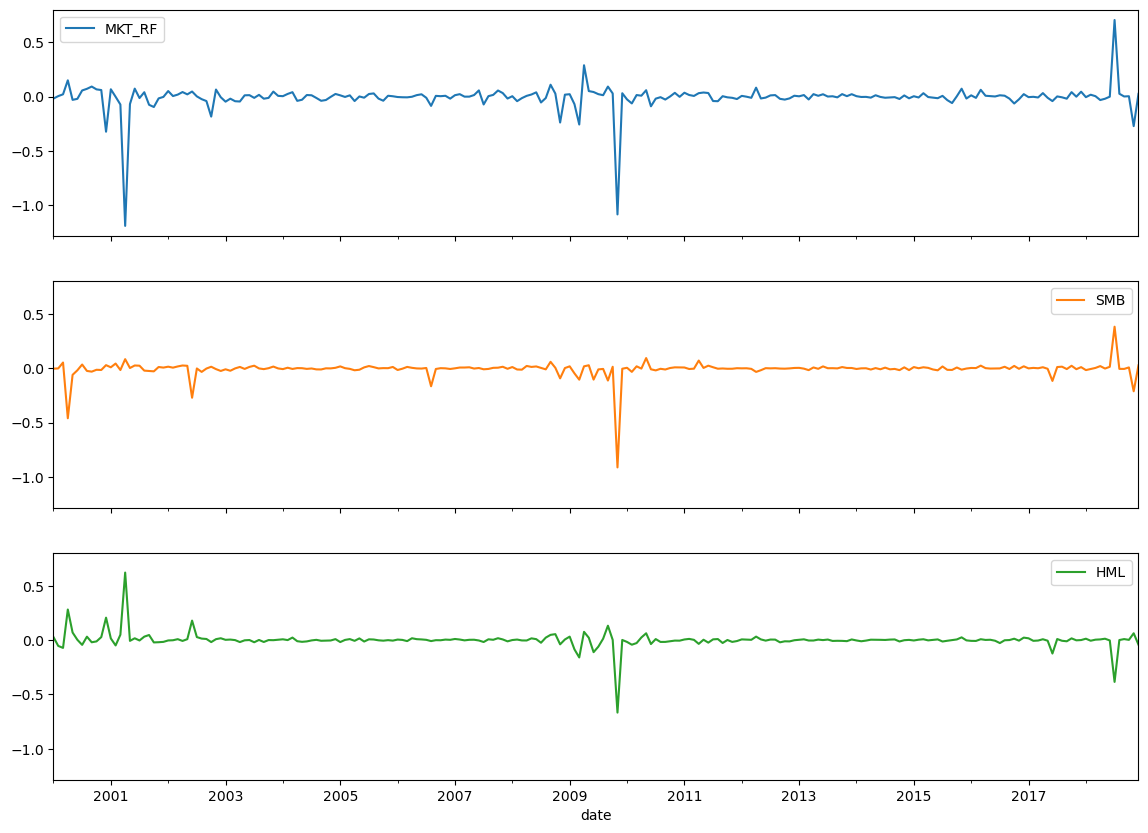

In [24]:
gammas_mat.iloc[:,1:4].plot( figsize=(14,10), subplots=True, sharey=True, sharex=True)
plt.show()

#### Factor competition (Correlation between factors)



The core purpose of factors is to explain the cross-section of stock returns. For theoretical and practical reasons, it is preferable if redundancies within factors are avoided. Indeed, redundancies imply collinearity which is known to perturb estimates (Belsley, Kuh, and Welsch (2005)). In addition, when asset managers decompose the performance of their returns into factors, overlaps (high absolute correlations) between factors yield exposures that are less interpretable; positive and negative exposures compensate each other spuriously.

A simple protocol to sort out redundant factors is to run regressions of each factor against all others:
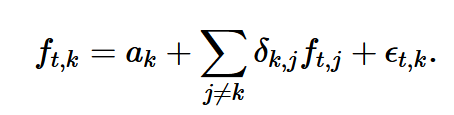

The interesting metric is then the test statistic associated to the estimation of ak. If ak is significantly different from zero, then the cross-section of (other) factors fails to explain exhaustively the average return of factor k

. Otherwise, the return of the factor can be captured by exposures to the other factors and is thus redundant.

One mainstream application of this technique was performed in Fama and French (2015), in which the authors show that the HML factor is redundant when taking into account four other factors (Market, SMB, RMW and CMA). Below, we reproduce their analysis on an updated sample. We start our analysis directly with the database maintained by Kenneth French.


We can run the regressions that determine the redundancy of factors via the procedure defined in Equation above

In [25]:
import numpy as np
import statsmodels.api as sm

df_res_full=[]
for i in range(0,5):
    factors_list_full = ["MKT_RF", "SMB", "HML", "RMW", "CMA"]
    factors_list_tmp=factors_list_full
    Y=FF_factors[factors_list_full[i]]
    factors_list_tmp.remove(factors_list_full[i])
    data=FF_factors[factors_list_tmp]
    results=sm.OLS(endog=Y,exog=sm.add_constant(data)).fit()
    results_param=results.params
    reg_result_tmp=pd.DataFrame(results_param)
    reg_result_tmp['factor_mnemo']=Y.name
    reg_result_tmp['pvalue']=results.pvalues
    df_res_full.append(reg_result_tmp)

df_res_full = pd.concat(df_res_full)
df_res_full.reset_index(inplace=True)
df_res_full.rename(columns={0: "coeff"},inplace=True)

In [26]:
df_res_full

,index,coeff,factor_mnemo,pvalue
0,const,0.007797,MKT_RF,3.695498e-07
1,SMB,0.257014,MKT_RF,1.554538e-06
2,HML,0.119662,MKT_RF,1.060663e-01
3,RMW,-0.362841,MKT_RF,1.096076e-06
4,CMA,-0.944782,MKT_RF,3.913856e-18
5,const,0.002742,SMB,1.287580e-02
6,MKT_RF,0.130880,SMB,1.554538e-06
7,HML,0.084593,SMB,1.093801e-01
8,RMW,-0.434396,SMB,9.304459e-17
9,CMA,-0.141599,SMB,7.580150e-02


We obtain the vector of α values from Equation (). Below, we format these figures along with p-value thresholds and export them in a summary table. The significance levels of coefficients is coded as follows:
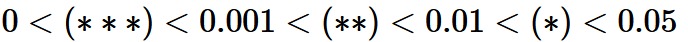

In [27]:
df_significance=df_res_full
conditions = [(df_significance['pvalue'] > 0) & (df_significance['pvalue'] < 0.001), # create a conditions' list
(df_significance['pvalue'] > 0.001) & (df_significance['pvalue'] < 0.01),
(df_significance['pvalue'] > 0.01) & (df_significance['pvalue'] < 0.05),
(df_significance['pvalue'] > 0.05)]

valuest = ['(***)','(**)','(*)','na'] # Values assign for each condition

# create a new column and use np.select to assign values to it using our lists as arguments
df_significance['significance'] = np.select(conditions, valuest).astype(str)
df_significance['coeff']=round(df_significance.coeff,3)
df_significance['coeff_stars']= df_significance.coeff.astype(str)+' '+df_significance.significance

# display updated DataFrame in the right shape
df_significance_pivot=df_significance.pivot(index='index',columns='factor_mnemo',values='coeff_stars').transpose()
df_significance_pivot= df_significance_pivot.reindex(columns=column_names_inverted)
df_significance_pivot.reindex(["MKT_RF", "SMB", "HML", "RMW", "CMA"])


index,const,MKT_RF,SMB,HML,RMW,CMA
factor_mnemo,,,,,,
MKT_RF,0.008 (***),NaN,0.257 (***),0.12 na,-0.363 (***),-0.945 (***)
SMB,0.003 (*),0.131 (***),NaN,0.085 na,-0.434 (***),-0.142 na
HML,-0.001 na,0.032 na,0.045 na,NaN,0.167 (***),1.027 (***)
RMW,0.004 (***),-0.095 (***),-0.224 (***),0.163 (***),NaN,-0.315 (***)
CMA,0.002 (***),-0.112 (***),-0.033 na,0.451 (***),-0.142 (***),NaN


We confirm that the HML factor remains redundant when the four others are present in the asset pricing model. The figures we obtain are very close to the ones in the original paper (Fama and French (2015)), which makes sense, since we only add 5 years to their initial sample.

#### Factors or Characteristic

The decomposition of returns into linear factor models is convenient because of its simple interpretation. There is nonetheless a debate in the academic literature about whether firm returns are indeed explained by exposure to macro-economic factors or simply by the characteristics of firms. In their early study, Lakonishok, Shleifer, and Vishny (1994) argue that one explanation of the value premium comes from incorrect extrapolation of past earning growth rates. Investors are overly optimistic about firms subject to recent profitability. Consequently, future returns are (also) driven by the core (accounting) features of the firm. The question is then to disentangle which effect is the most pronounced when explaining returns: characteristics versus exposures to macro-economic factors.

#### Factor Momnetum

A recent body of literature unveils a time series momentum property of factor returns. For instance, Gupta and Kelly (2019) report that autocorrelation patterns within these returns is statistically significant

Given the data obtained on Ken French’s website, we compute the autocorrelation function (ACF) of factors. We recall that

Acknowledging the profitability of factor momentum, H. Yang (2020b) seeks to understand its source and decomposes stock factor momentum portfolios into two components: factor timing portfolio and a static portfolio. The former seeks to profit from the serial correlations of factor returns while the latter tries to harness factor premia. The author shows that it is the static portfolio that explains the larger portion of factor momentum returns. In H. Yang (2020a), the same author presents a new estimator to gauge factor momentum predictability. Words of caution are provided in Leippold and Yang (2021).



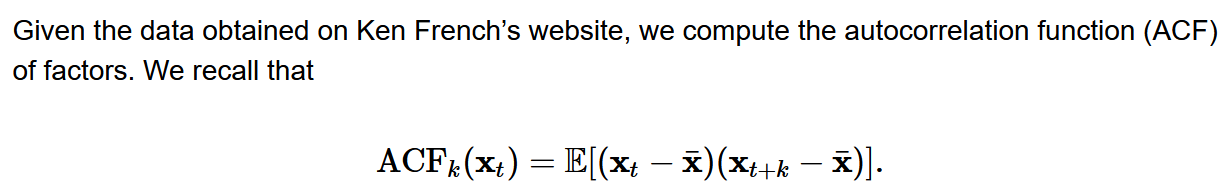

In [79]:
############## Autocorrelograms of common factor portfolios ##################################

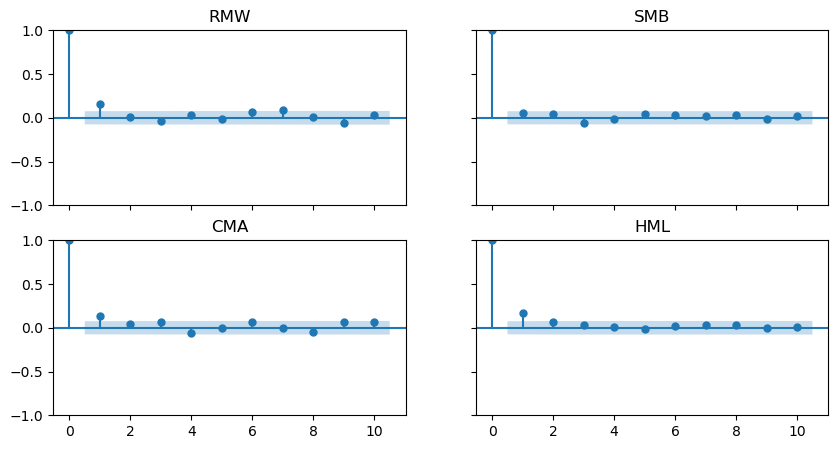

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

fig, ax = plt.subplots(2,2,figsize=(10,5),sharex='all', sharey='all') # how to
sm.graphics.tsa.plot_acf(FF_factors.RMW, lags=10, ax=ax[0,0],title='RMW') # chek fo rthe name 
sm.graphics.tsa.plot_acf(FF_factors.CMA, lags=10, ax=ax[1,0],title='CMA')
sm.graphics.tsa.plot_acf(FF_factors.SMB, lags=10, ax=ax[0,1],title='SMB')
sm.graphics.tsa.plot_acf(FF_factors.HML, lags=10, ax=ax[1,1],title='HML')
plt.show()

Of the four chosen series, only the size factor is not significantly autocorrelated at the first order.

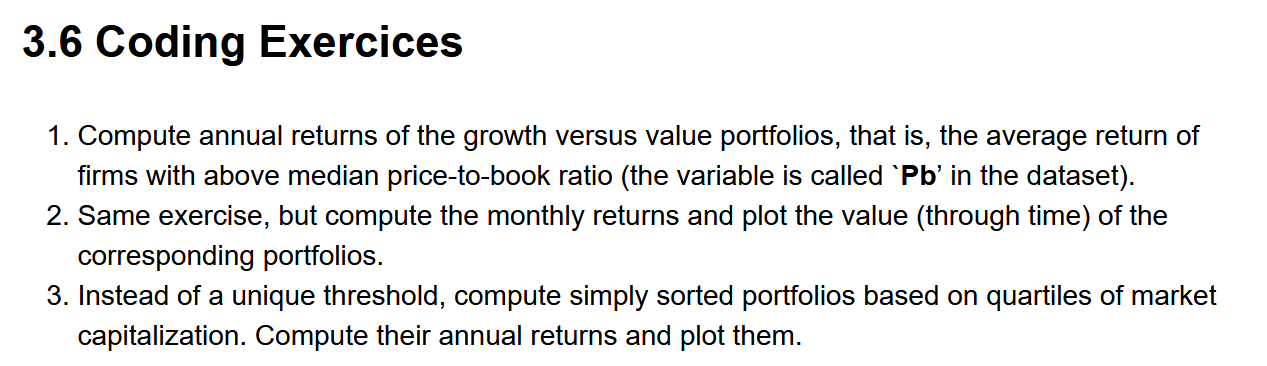

#### Data Preprocessing

In [29]:
features_short

['Div_Yld', 'Eps', 'Mkt_Cap_12M_Usd', 'Mom_11M_Usd', 'Ocf', 'Pb', 'Vol1Y_Usd']

In [26]:
######################## Swarnplot of correlations with the 1M forward return #############################

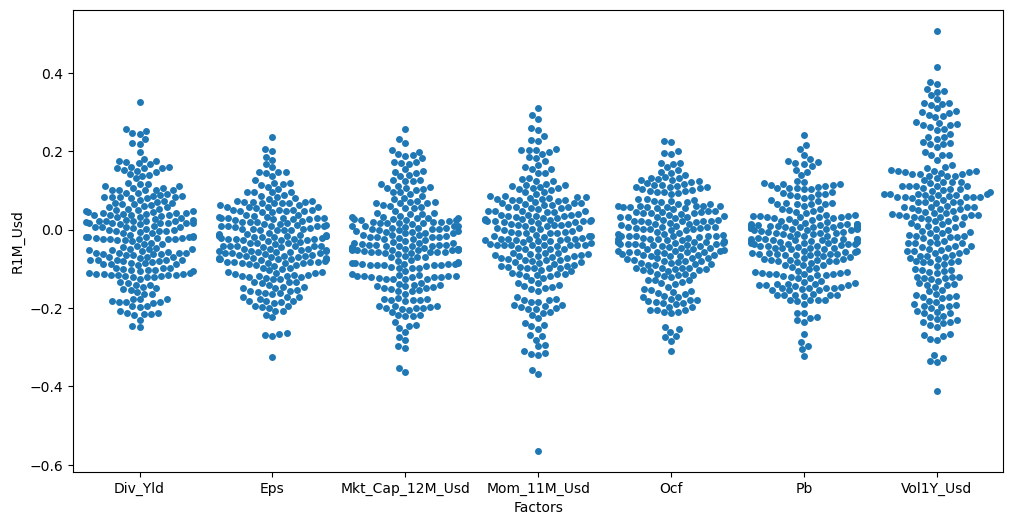

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

cols=[]                                 # cleaning the column list from previous use
cols= features_short+['R1M_Usd','date'] # Keep few features, label & dates
data_corr = data_ml[cols]               # Creating the working dataset
data_corr = data_corr.groupby('date').corr()[['R1M_Usd']].reset_index() # Group for computing correlation
data_corr= data_corr.loc[data_corr[data_corr.level_1.str[-7:] != "R1M_Usd"].index] # removing correl=1 instances from label
data_corr.rename(columns={'level_1': "Factors"},inplace=True) # Renaming for plotting later
plt.figure(figsize=(12,6))              # resizing the chart
sns.swarmplot(x="Factors", y="R1M_Usd", data=data_corr); # Plot from seaborn

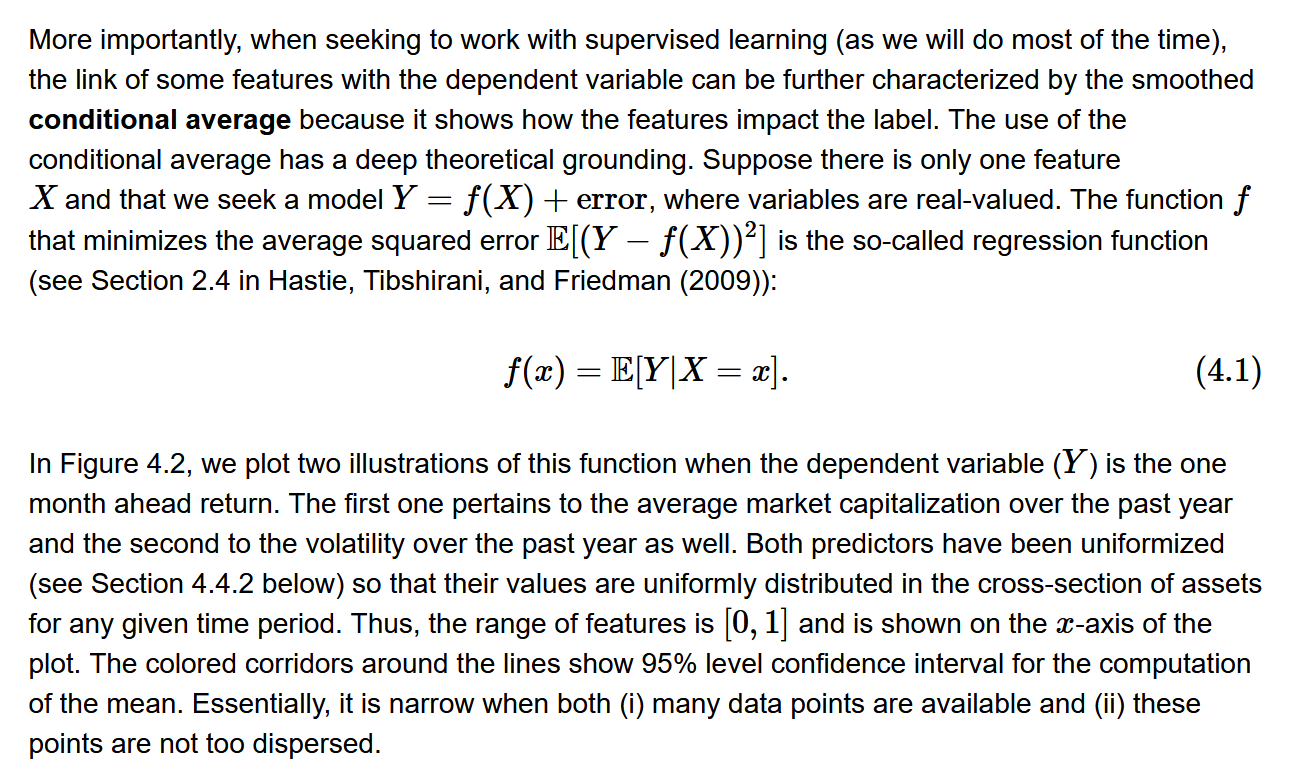

In [102]:
######### Conditional expectations: average returns as smooth functions of features #######################

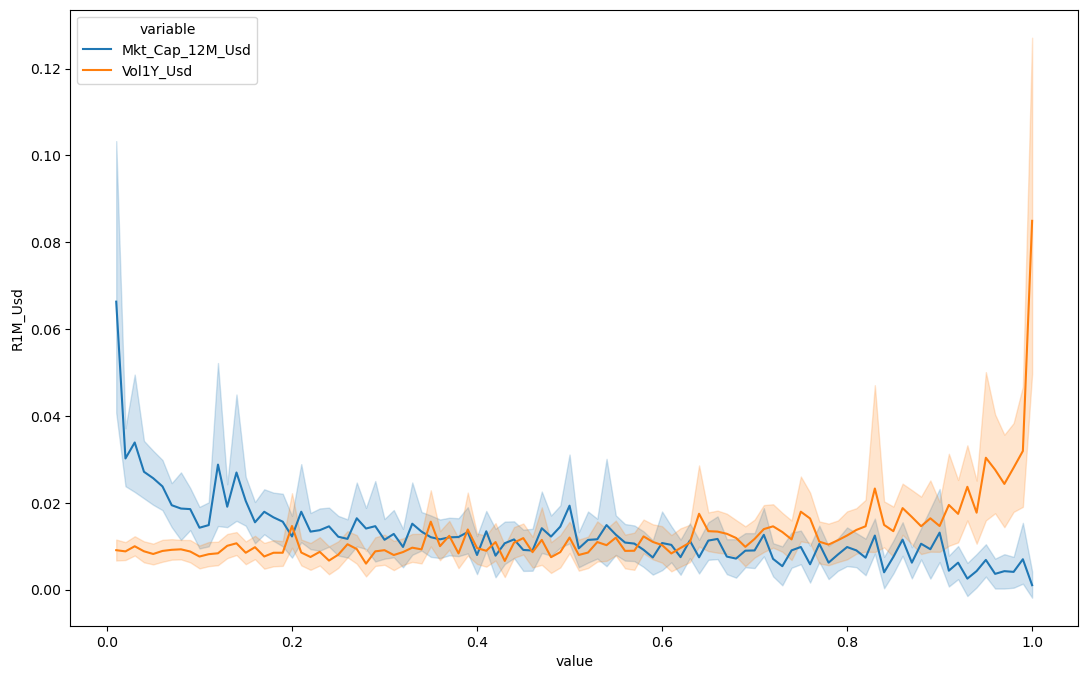

In [31]:
#For a value on x-axis how dispersed y values are 
from matplotlib import pyplot as plt
import seaborn as sns

unpivoted_data_ml = pd.melt(data_ml[['R1M_Usd','Mkt_Cap_12M_Usd','Vol1Y_Usd']], id_vars='R1M_Usd') # selecting and putting in vector
plt.figure(figsize=(13,8))
sns.lineplot(data = unpivoted_data_ml, y='R1M_Usd', x='value', hue='variable'); # Plot from seaborn

The two variables have a close to monotonic impact on future returns. Returns, on average, decrease with market capitalization (thereby corroborating the so-called size effect). The reverse pattern is less pronounced for volatility: the curve is rather flat for the first half of volatility scores and progressively increases, especially over the last quintile of volatility values (thereby contradicting the low-volatility anomaly).

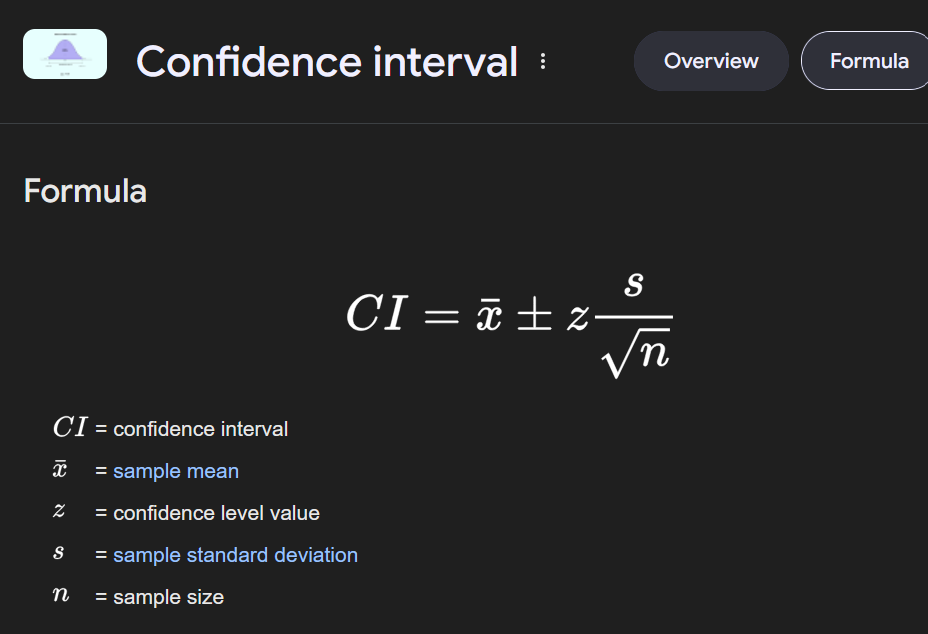

In [123]:
########## we build the histogram of autocorrelations, computed stock-by-stock and feature-by-feature.

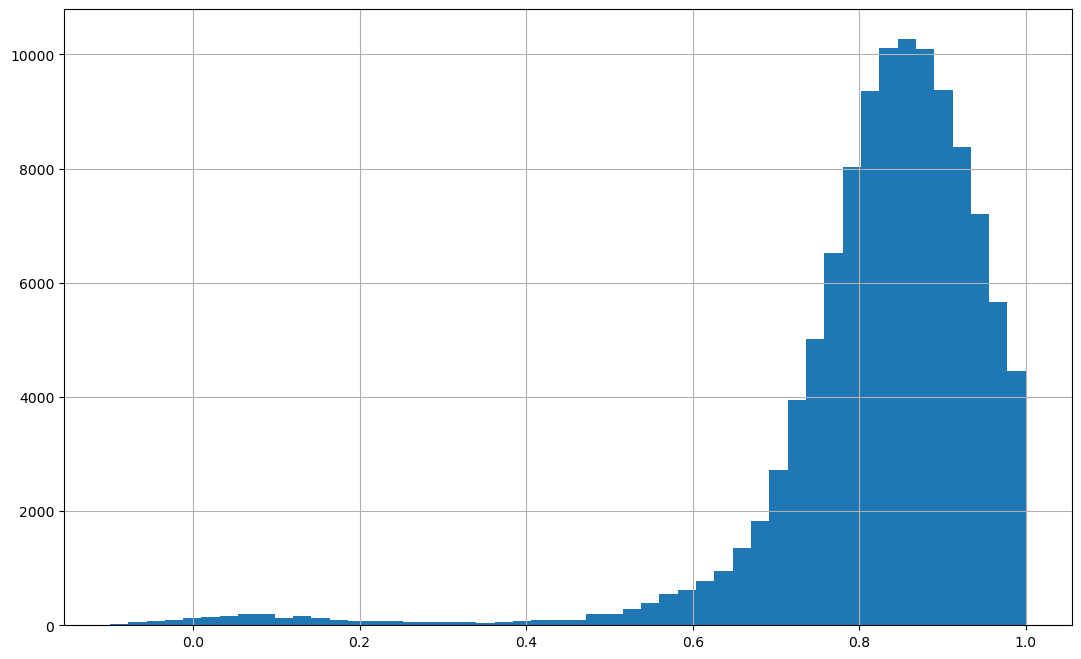

In [32]:
cols=[]                                 # cleaning the column list from previous use
cols = ['stock_id'] + list(data_ml.iloc[:,3:95].columns) # Keep all features and stockid
# below the nested line of code for sorting according the pair stockid/variable and then compute the acf
data_hist_acf=pd.melt(data_ml[cols], id_vars='stock_id').groupby(['stock_id','variable']).apply(lambda x: x['value'].autocorr(lag=1))
plt.figure(figsize=(13,8))
data_hist_acf.hist(bins=50,range=[-0.1,1]); # Plot from pandas

In [33]:
#autocorrelation with lag 1
series1 = pd.Series([1, 2, 3, 4, 5, 6])
series1.corr(series1.shift(1)), series1.shift(1)

(0.9999999999999999,
 0    NaN
 1    1.0
 2    2.0
 3    3.0
 4    4.0
 5    5.0
 dtype: float64)

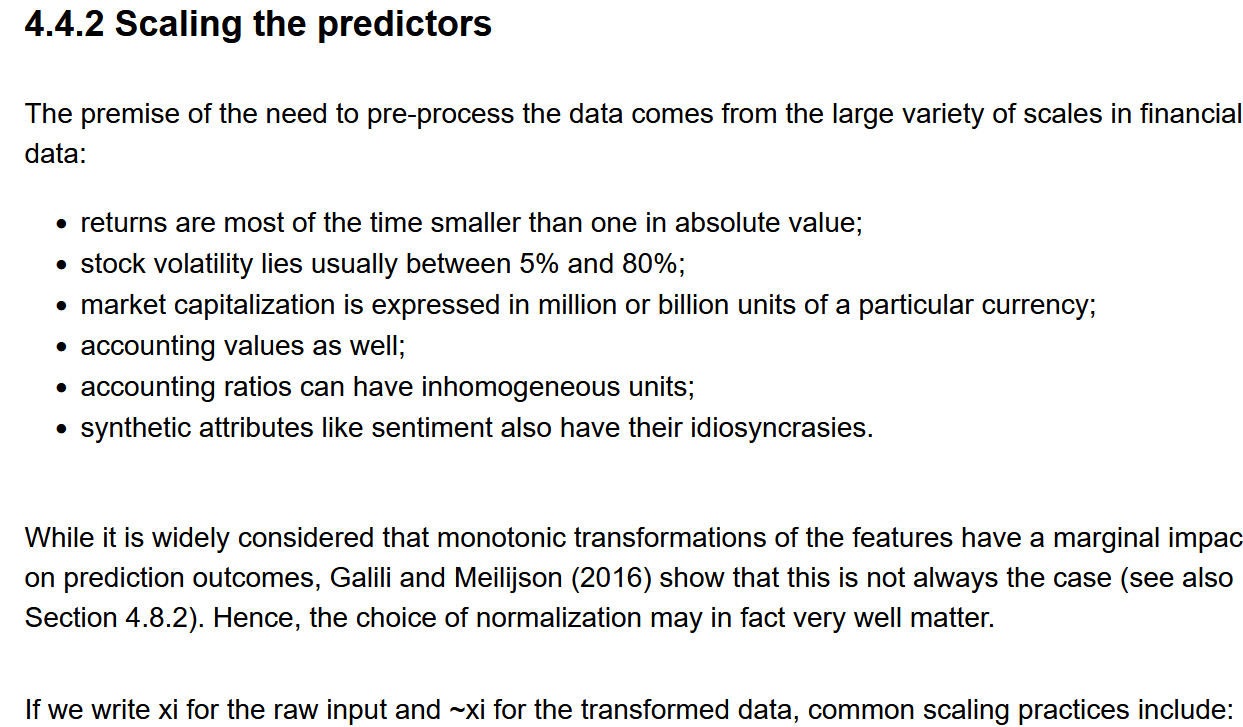
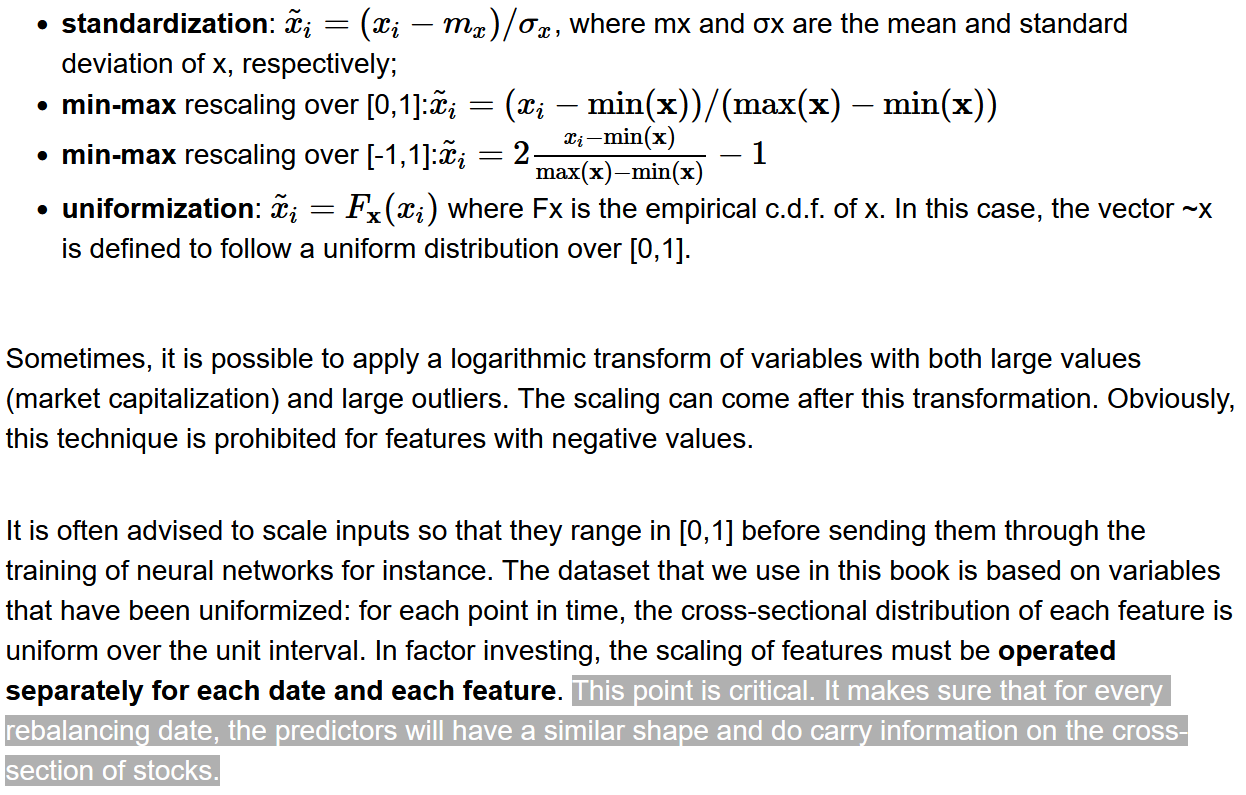
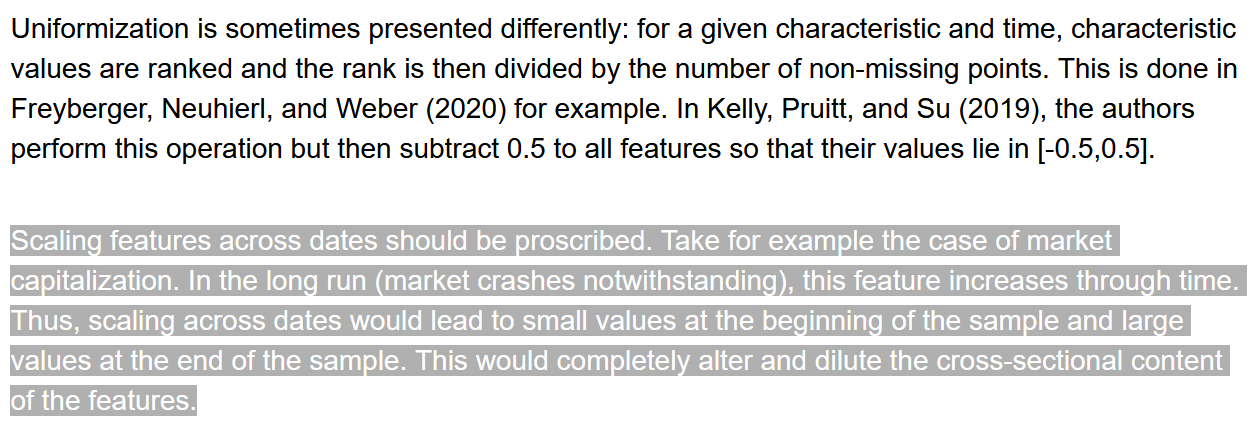

<!--Why CDF of a random variable follows Uniform distribution

#https://stats.stackexchange.com/questions/161635/why-is-the-cdf-of-a-sample-uniformly-distributed
Here's some intuition. Let's use a discrete example.

Say after an exam the students' scores are X=[10,50,60,90]
. But you want the scores to be more even or uniform. h(X)=[25,50,75,100]

looks better.

One way to achieve this is to find the percentiles of each student's score. Score 10
is 25%, score 50 is 50%

, and so on. Note that the percentile is just the CDF. So the CDF of a sample is "uniform".

When X
is a random variable, the percentile of X is "uniform" (e.g. the number of X's in 0−25 percentile should be the same as the number of X's in 25−50 percentile). Therefore the CDF of X is uniformly distributed.-->


<!--
## Why CDF of a random variable follows Uniform distribution

#https://stats.stackexchange.com/questions/161635/why-is-the-cdf-of-a-sample-uniformly-distributed
Here's some intuition. Let's use a discrete example.

Say after an exam the students' scores are X=[10,50,60,90]
. But you want the scores to be more even or uniform. h(X)=[25,50,75,100]

looks better.

One way to achieve this is to find the percentiles of each student's score. Score 10
is 25%, score 50 is 50%

, and so on. Note that the percentile is just the CDF. So the CDF of a sample is "uniform".

When X
is a random variable, the percentile of X is "uniform" (e.g. the number of X's in 0−25 percentile should be the same as the number of X's in 25−50 percentile). Therefore the CDF of X is uniformly distributed.
-->


In [44]:
#Explore how scaling is done for market capitalisation in data_ml
#In chapter 1-----> The predictors have been uniformized, that is, for any given feature and time point, 
# the distribution is uniform. 
# Given 1,207 stocks, the graph below cannot display a perfect rectangle.

Text(0, 0.5, 'count')

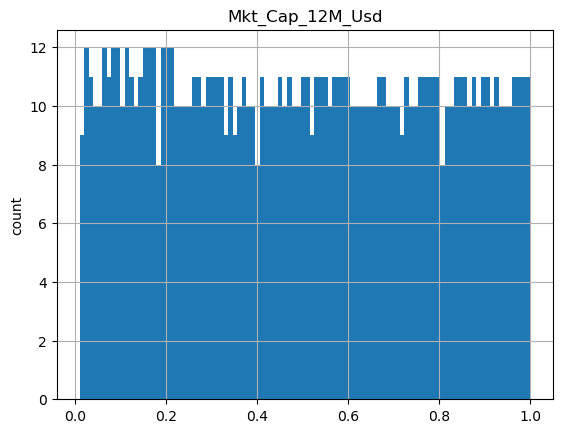

In [34]:
# data_ml[data_ml['date']=='2006-12-31']['Mkt_Cap_12M_Usd'].values
col_feat_mcap =data_ml.columns.get_loc('Mkt_Cap_12M_Usd') # finding the location of the column/feature Mkt_Cap_12M_Usd
is_custom_date = data_ml['date']=='2000-02-29'       # creating a boolean index to filter on 
data_ml[is_custom_date].iloc[:,[col_feat_mcap]].hist(bins=100) # using the hist , see uniform distribution of spread of mkt_cap
plt.ylabel('count')

Text(0, 0.5, 'count')

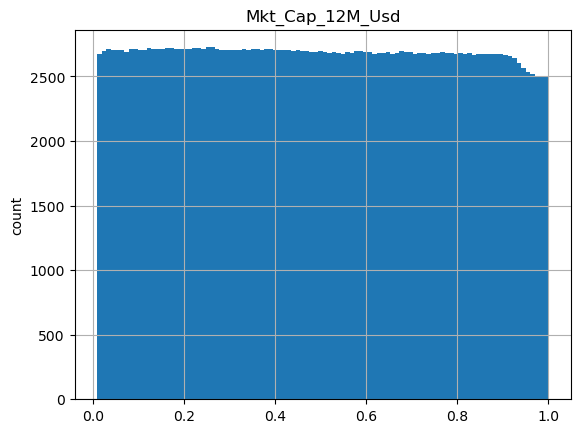

In [35]:
col_feat_mcap =data_ml.columns.get_loc('Mkt_Cap_12M_Usd') # finding the location of the column/feature Mkt_Cap_12M_Usd

data_ml.iloc[:,[col_feat_mcap]].hist(bins=100) # using the hist , see uniform distribution of spread of mkt_cap
plt.ylabel('count')

In [32]:
# '''
# ## Why CDF of a random variable follows Uniform distribution

# #https://stats.stackexchange.com/questions/161635/why-is-the-cdf-of-a-sample-uniformly-distributed
# Here's some intuition. Let's use a discrete example.

# Say after an exam the students' scores are X=[10,50,60,90]
# . But you want the scores to be more even or uniform. h(X)=[25,50,75,100]

# looks better.

# One way to achieve this is to find the percentiles of each student's score. Score 10
# is 25%, score 50 is 50%

# , and so on. Note that the percentile is just the CDF. So the CDF of a sample is "uniform".

# When X
# is a random variable, the percentile of X is "uniform" (e.g. the number of X's in 0−25 percentile should be the same as the number of X's in 25−50 percentile). Therefore the CDF of X is uniformly distributed.
# '''

Cross-sectional data is a collection of observations of many subjects or objects at a single point in time. It's used to capture multiple variables simultaneously, and is often used to compare differences between subjects. 
Cross-sectional data is different from time-series data, which is recorded in a meaningful sequence. Cross-sectional data is also different from longitudinal data, where there are multiple observations for each unit over time. 
Here are some examples of cross-sectional data:

    Comparing the financial statements of companies at a fixed date 

Examining the GDP of different countries in a single year 
The gross annual income for each of 1,000 randomly chosen households in New York City for the year 2000 

#### Triple Barrier Labelling---> Advances in Financial MAchine Learning (Marcos Lopez del Prado)

The rationale for this extension is that often money managers implement P&L triggers that cash in when gains are sufficient or opt out to stop their losses. Upon inception of the strategy, three barriers are fixed (see Figure 4.4):

    one above the current level of the asset (magenta line), which measures a reasonable expected profit;
    one below the current level of the asset (cyan line), which acts as a stop-loss signal to prevent large     negative returns;
    and finally, one that fixes the horizon of the strategy after which it will be terminated (black line).

If the strategy hits the first (resp. second) barrier, the output is +1 (resp. -1), and if it hits the last barrier, the output is equal to zero or to some linear interpolation (between -1 and +1) that represents the position of the terminal value relative to the two horizontal barriers. Computationally, this method is much more demanding, as it evaluates a whole trajectory for each instance. Again, it is nonetheless considered as more realistic because trading strategies are often accompanied with automatic triggers such as stop-loss, etc.


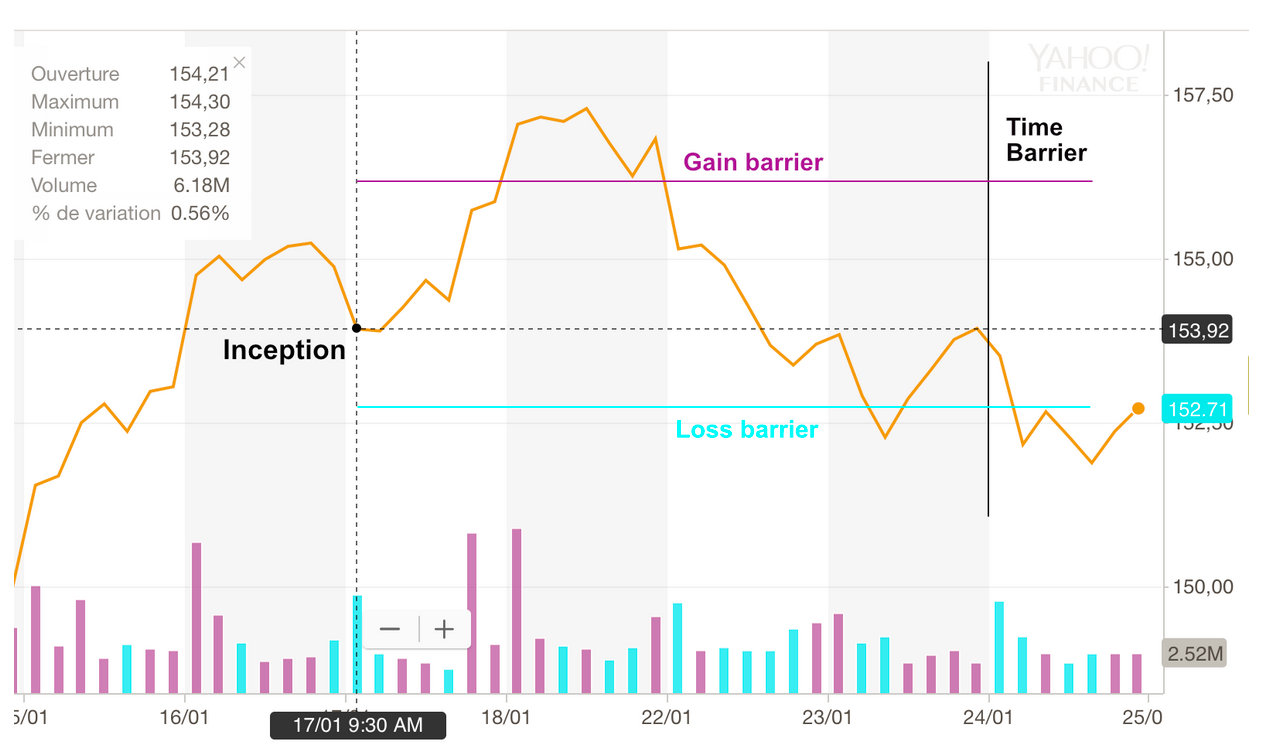

In [37]:
#########################################      Additional Code     #######################################

Impact of rescaling: graphical representation

We start with a simple illustration of the different scaling methods. We generate an arbitrary series and then rescale it. The series is not random so that each time the code chunk is executed, the output remains the same.

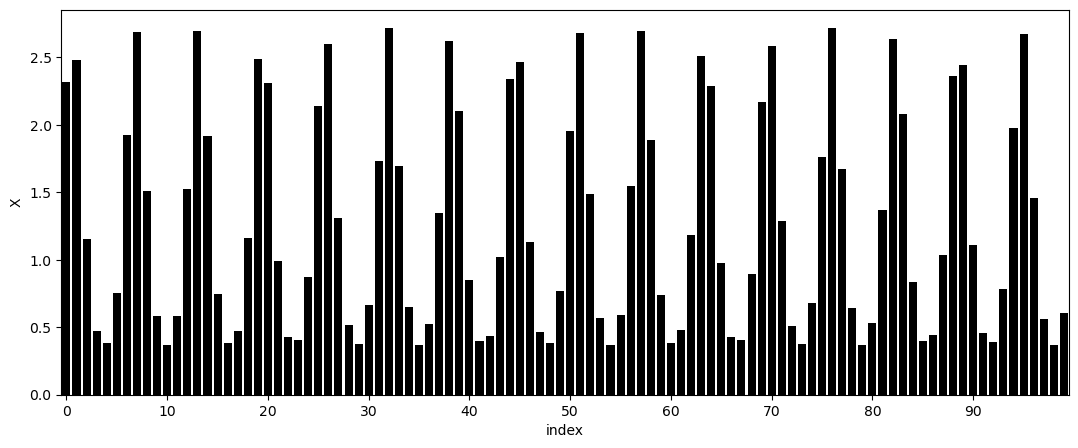

In [38]:
length = 100
x = np.exp(np.sin(np.linspace(1,length,length)))
data = pd.DataFrame(data=x,columns=['X'])
data.reset_index(inplace=True)
plt.figure(figsize=(13,5)) # resizing figure
sns.barplot(y="X", data=data, x="index", color='black'); # Plot from Seaborn
plt.xticks(data['index'][::10]);   # reshape the xtick every 10 observations

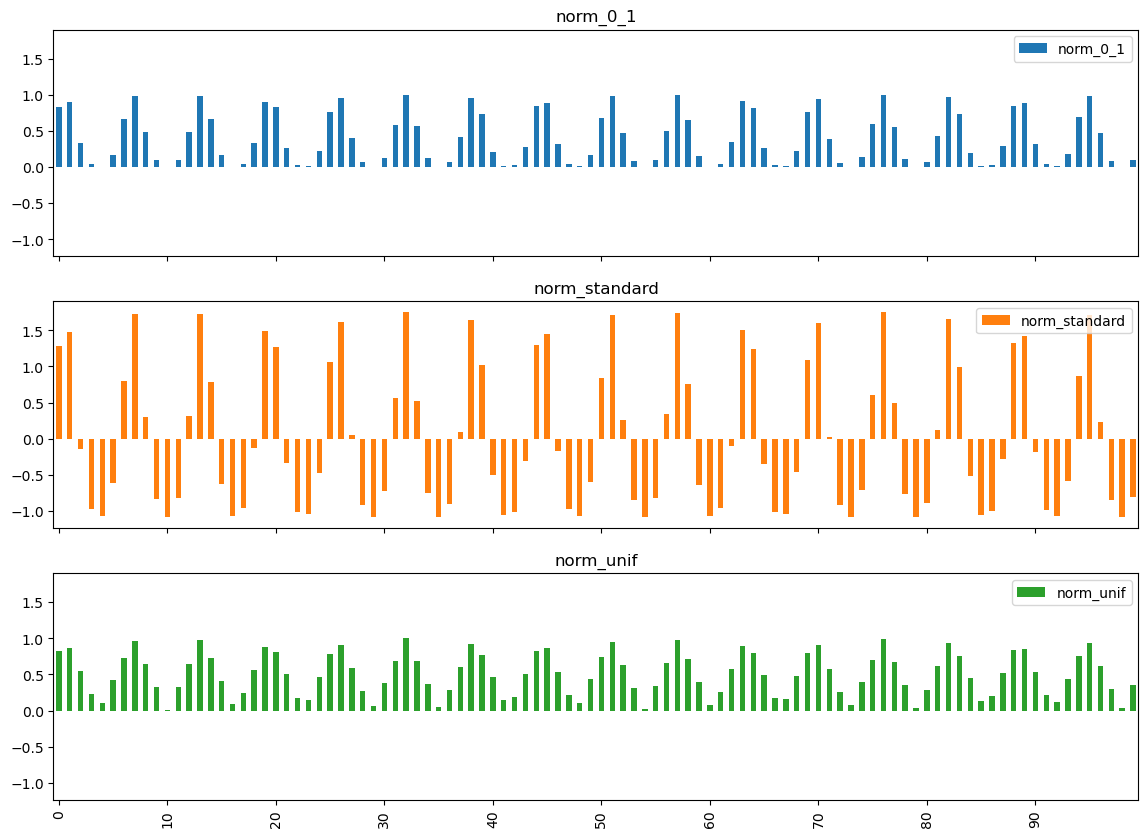

In [39]:
from statsmodels.distributions.empirical_distribution import ECDF # to use the ECDF built in function

def norm_0_1(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

def norm_unif(x):
    return (ECDF(x)(x))

def norm_standard(x):
    return (x- np.mean(x))/np.std(x)

data_norm=pd.DataFrame.from_dict(dict( # ensembling numpy arrays into a dict and then a pd dataframe
index=np.linspace(1,length,length), # creating the index
norm_0_1=norm_0_1(x), # normalisation [0,1]
norm_standard=norm_standard(x), # standardisation
norm_unif=norm_unif(x))) # Uniformisation
data_norm.iloc[:,1:4].plot.bar( figsize=(14,10), subplots=True, sharey=True, sharex=True); # Plot
plt.xticks(data['index'][::10]);   # reshape the xtick every 10 observations

Finally, we look at the histogram of the newly created variables

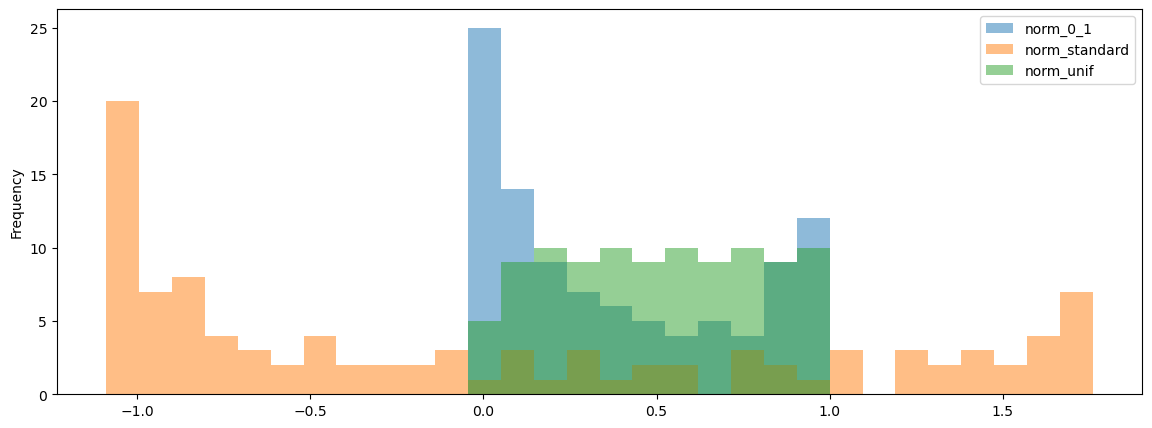

In [40]:
data_norm.iloc[:,1:4].plot.hist(alpha=0.5, bins=30, figsize=(14,5)); # Plot from pandas, alphas=opacity

With respect to shape, the blue and orange distributions are close to the original one. It is only the support that changes: the min/max rescaling ensures all values lie in the [0,1] interval. In both cases, the smallest values (on the left) display a spike in distribution. By construction, this spike disappears under the uniformization: the points are evenly distributed over the unit interval.

In [55]:
# Impact of rescaling: toy example

To illustrate the impact of choosing one particular rescaling method we build a simple dataset, comprising 3 firms and 3 dates.

In [41]:
import statsmodels.api as sm
from IPython.display import display, Markdown
cap=np.array([10,50,100, # Market capitalization
              15,10,15,
              200,120,80])
returns=np.array([0.06,0.01,-0.06, # Return values
        -0.03,0.00,0.02,
        -0.04,-0.02,0.00])
date=np.array([1,2,3,1,2,3,1,2,3]) # Dates
firm=np.array([1,1,1,2,2,2,3,3,3]) # Firms (3 lines for each)
toy_data=pd.DataFrame.from_dict(dict(firm=firm,date=date,cap=cap,returns=returns, # Aggregation of data
cap_norm=norm_0_1(cap),
cap_u=norm_unif(cap))) 
display(Markdown(toy_data.to_markdown())) # Introducing Markdown and printing the table

|    |   firm |   date |   cap |   returns |   cap_norm |    cap_u |
|---:|-------:|-------:|------:|----------:|-----------:|---------:|
|  0 |      1 |      1 |    10 |      0.06 |  0         | 0.222222 |
|  1 |      1 |      2 |    50 |      0.01 |  0.210526  | 0.555556 |
|  2 |      1 |      3 |   100 |     -0.06 |  0.473684  | 0.777778 |
|  3 |      2 |      1 |    15 |     -0.03 |  0.0263158 | 0.444444 |
|  4 |      2 |      2 |    10 |      0    |  0         | 0.222222 |
|  5 |      2 |      3 |    15 |      0.02 |  0.0263158 | 0.444444 |
|  6 |      3 |      1 |   200 |     -0.04 |  1         | 1        |
|  7 |      3 |      2 |   120 |     -0.02 |  0.578947  | 0.888889 |
|  8 |      3 |      3 |    80 |      0    |  0.368421  | 0.666667 |



Let’s briefly comment on this synthetic data. We assume that dates are ordered chronologically and far away: each date stands for a year or the beginning of a decade, but the (forward) returns are computed on a monthly basis. The first firm is hugely successful and multiplies its cap ten times over the periods. The second firm remains stable cap-wise, while the third one plummets. If we look at ‘local’ future returns, they are strongly negatively related to size for the first and third firms. For the second one, there is no clear pattern.

Date-by-date, the analysis is fairly similar, though slightly nuanced.

    On date 1, the smallest firm has the largest return and the two others have negative returns.
    On date 2, the biggest firm has a negative return while the two smaller firms do not.
    On date 3, returns are decreasing with size. While the relationship is not always perfectly monotonous, there seems to be a link between size and return and, typically, investing in the smallest firm would be a very good strategy with this sample.

Now let us look at the output of simple regressions.


In [60]:
####################### Regression output when the independent var. comes from min-max rescaling

In [42]:
X=toy_data.cap_norm.to_numpy()
X=sm.add_constant(X)
model = sm.OLS(returns, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     4.265
Date:                Wed, 11 Dec 2024   Prob (F-statistic):             0.0778
Time:                        14:09:12   Log-Likelihood:                 19.892
No. Observations:                   9   AIC:                            -35.78
Df Residuals:                       7   BIC:                            -35.39
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0124      0.014      0.912      0.3

In [59]:
############################ Regression output when the indep. var. comes from uniformization

In [43]:
X=toy_data.cap_u.to_numpy()
X=sm.add_constant(X)
model = sm.OLS(returns, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     6.672
Date:                Wed, 11 Dec 2024   Prob (F-statistic):             0.0363
Time:                        14:09:15   Log-Likelihood:                 20.764
No. Observations:                   9   AIC:                            -37.53
Df Residuals:                       7   BIC:                            -37.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0457      0.022      2.056      0.0



In terms of p-value (column P>|t|), the first estimation for the cap coefficient is above 5% (in Table 4.4) while the second is below 5% (in Table 4.5). One possible explanation for this discrepancy is the standard deviation of the variables. The deviations are equal to 0.34 and 0.27 for cap_norm and cap_u, respectively. Values like market capitalizations can have very large ranges and are thus subject to substantial deviations (even after scaling). Working with uniformized variables reduces dispersion and can help solve this problem.

Note that this is a double-edged sword: while it can help avoid false negatives, it can also lead to false positives.



#### Regression

In [58]:
features

['Advt_3M_Usd',
 'Advt_6M_Usd',
 'Asset_Turnover',
 'Bb_Yld',
 'Bv',
 'Capex_Ps_Cf',
 'Capex_Sales',
 'Cash_Div_Cf',
 'Cash_Per_Share',
 'Cf_Sales',
 'Debtequity',
 'Div_Yld',
 'Dps',
 'Ebit_Bv',
 'Ebit_Noa',
 'Ebit_Oa',
 'Ebit_Ta',
 'Ebitda_Margin',
 'Eps',
 'Eps_Basic',
 'Eps_Basic_Gr',
 'Eps_Contin_Oper',
 'Eps_Dil',
 'Ev',
 'Ev_Ebitda',
 'Fa_Ci',
 'Fcf',
 'Fcf_Bv',
 'Fcf_Ce',
 'Fcf_Margin',
 'Fcf_Noa',
 'Fcf_Oa',
 'Fcf_Ta',
 'Fcf_Tbv',
 'Fcf_Toa',
 'Fcf_Yld',
 'Free_Ps_Cf',
 'Int_Rev',
 'Interest_Expense',
 'Mkt_Cap_12M_Usd',
 'Mkt_Cap_3M_Usd',
 'Mkt_Cap_6M_Usd',
 'Mom_11M_Usd',
 'Mom_5M_Usd',
 'Mom_Sharp_11M_Usd',
 'Mom_Sharp_5M_Usd',
 'Nd_Ebitda',
 'Net_Debt',
 'Net_Debt_Cf',
 'Net_Margin',
 'Netdebtyield',
 'Ni',
 'Ni_Avail_Margin',
 'Ni_Oa',
 'Ni_Toa',
 'Noa',
 'Oa',
 'Ocf',
 'Ocf_Bv',
 'Ocf_Ce',
 'Ocf_Margin',
 'Ocf_Noa',
 'Ocf_Oa',
 'Ocf_Ta',
 'Ocf_Tbv',
 'Ocf_Toa',
 'Op_Margin',
 'Op_Prt_Margin',
 'Oper_Ps_Net_Cf',
 'Pb',
 'Pe',
 'Ptx_Mgn',
 'Recurring_Earning_Total_Assets',

We begin with simple illustrations of penalized regressions. We start with the LASSO. The illustrations are run on the whole dataset. First, we estimate the coefficients. By default, the function chooses a large array of penalization values so that the results for different penalization intensities (λ) can be shown immediately.

In [46]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
y_penalized = data_ml['R1M_Usd'].values # Dependent variable
X_penalized = data_ml[features].values # Predictors
alphas = np.arange(1e-4,1.0e-3,1e-5) # here alpha is used for lambda in scikit-learn
lasso_res = {} # declaring the dict that will receive the model's result

Once the coefficients are computed, they require some wrangling before plotting. Also, there are too many of them, so we only plot a subset of them.

In [ ]:
######### LASSO model. The dependent variable is the 1 month ahead return.#####################

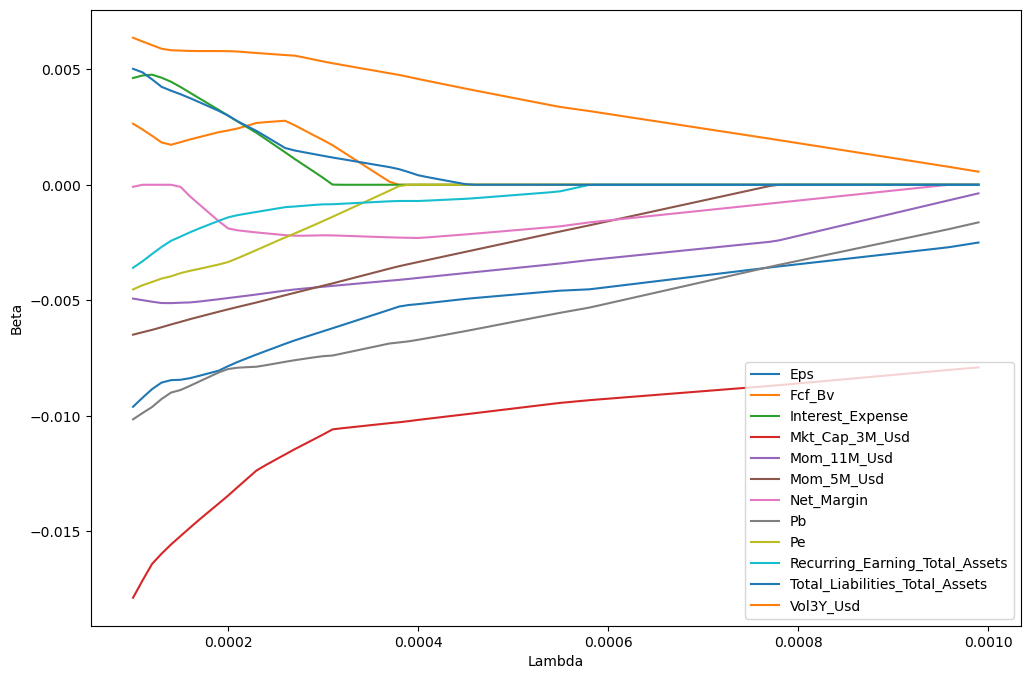

In [47]:
for alpha in alphas: # looping through the different alphas/lambdas values
        lasso = Lasso(alpha=alpha) # model
        lasso.fit(X_penalized,y_penalized) 
        lasso_res[alpha] = lasso.coef_ # extract LASSO coefs

df_lasso_res = pd.DataFrame.from_dict(lasso_res).T # transpose the dataframe for plotting
df_lasso_res.columns = features # adding the names of the factors
predictors = (df_lasso_res.abs().sum(axis = 0) > 0.05) # selecting the most relevant
df_lasso_res.loc[:,predictors].plot(xlabel='Lambda',ylabel='Beta',figsize=(12,8)); # Plot!

The graph plots the evolution of coefficients as the penalization intensity,λ, increases. For some characteristics, like Ebit_Ta (in orange), the convergence to zero is rapid. Other variables resist the penalization longer, like Mkt_Cap_3M_Usd, which is the last one to vanish. Essentially, this means that at the first order, this variable is an important driver of future 1-month returns in our sample. Moreover, the negative sign of its coefficient is a confirmation (again, in this sample) of the size anomaly, according to which small firms experience higher future returns compared to their larger counterparts.

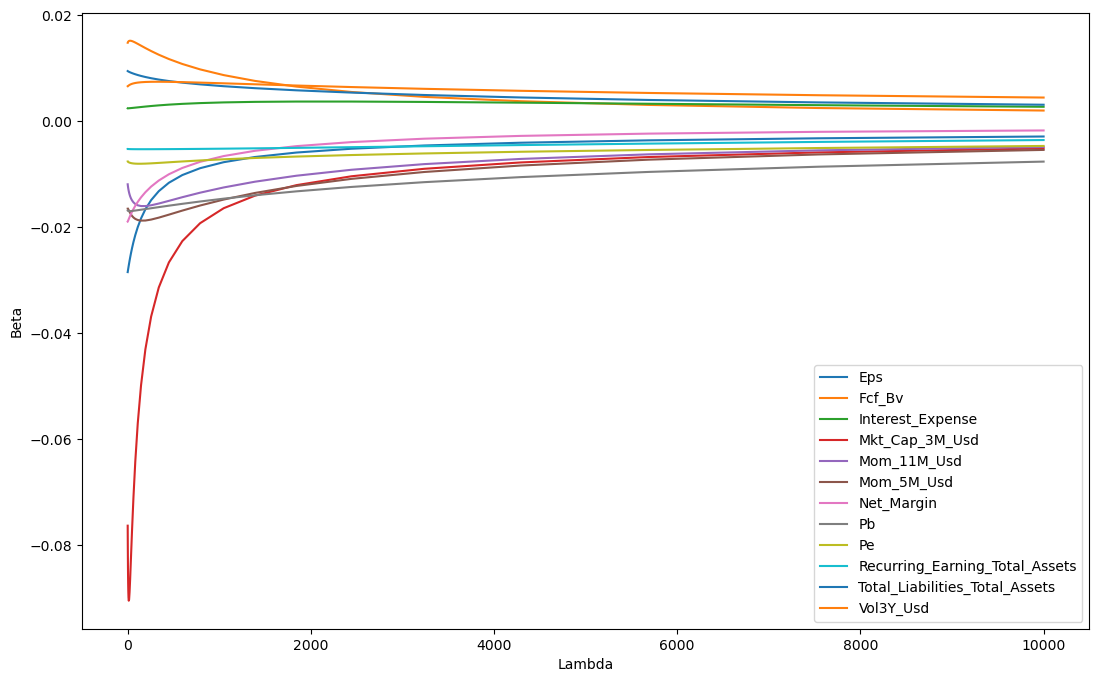

In [56]:
n_alphas = 50 # declare the number of alphas for ridge
alphas = np.logspace(-2, 4, n_alphas) # transforming into log for Aspect ratio 
ridge_res = {} # declaring the dict that will receive the model's result 

for alpha in alphas: # looping through the different alphas/lambdas values
    ridge = Ridge(alpha=alpha) # model
    ridge.fit(X_penalized,y_penalized) # fit the model
    ridge_res[alpha] = ridge.coef_ # extract RIDGE coefs

df_ridge_res = pd.DataFrame.from_dict(ridge_res).T # transpose the dataframe for plotting
df_ridge_res.columns = features # adding the names of the factors
df_ridge_res.loc[:,predictors].plot(xlabel='Lambda',ylabel='Beta',figsize=(13,8)); # Plot!

#### Sparse hedging for minimum variance portfolios

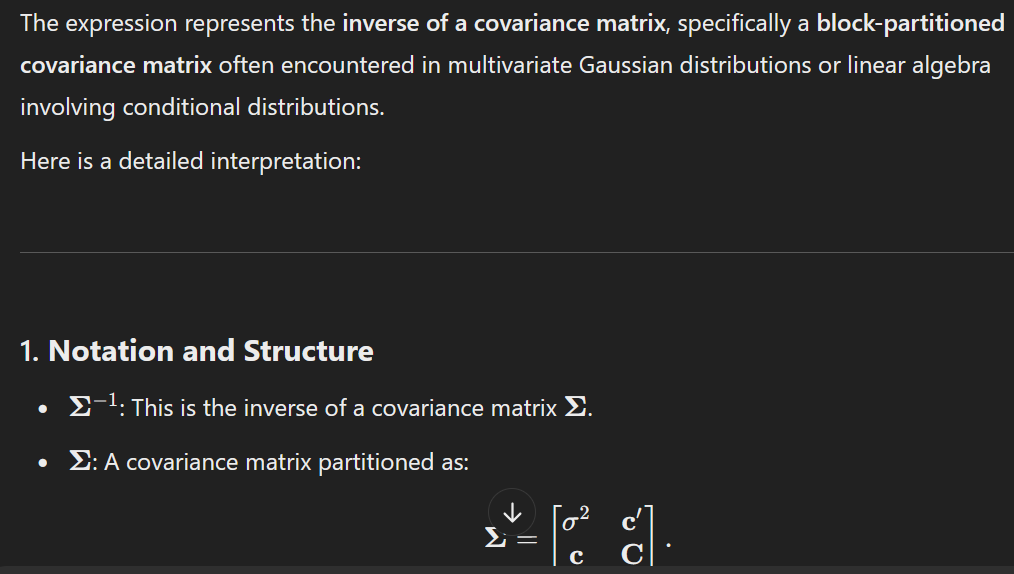
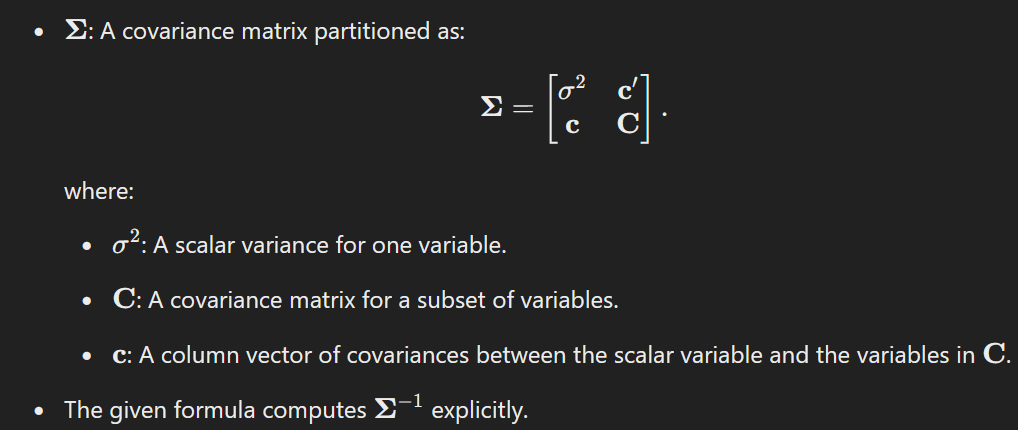
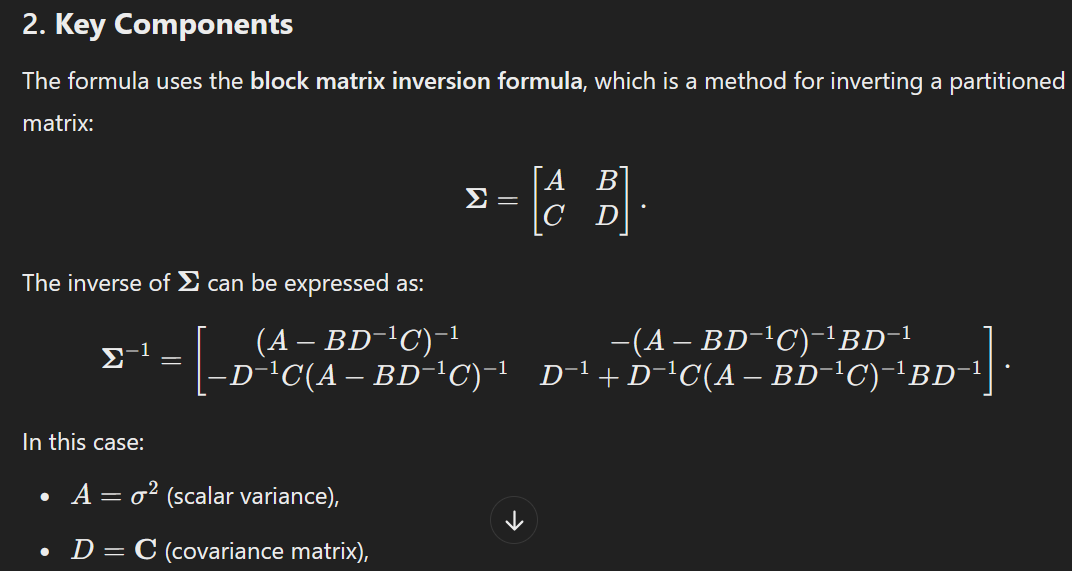
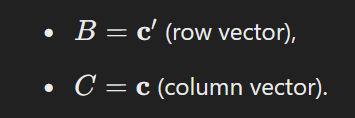
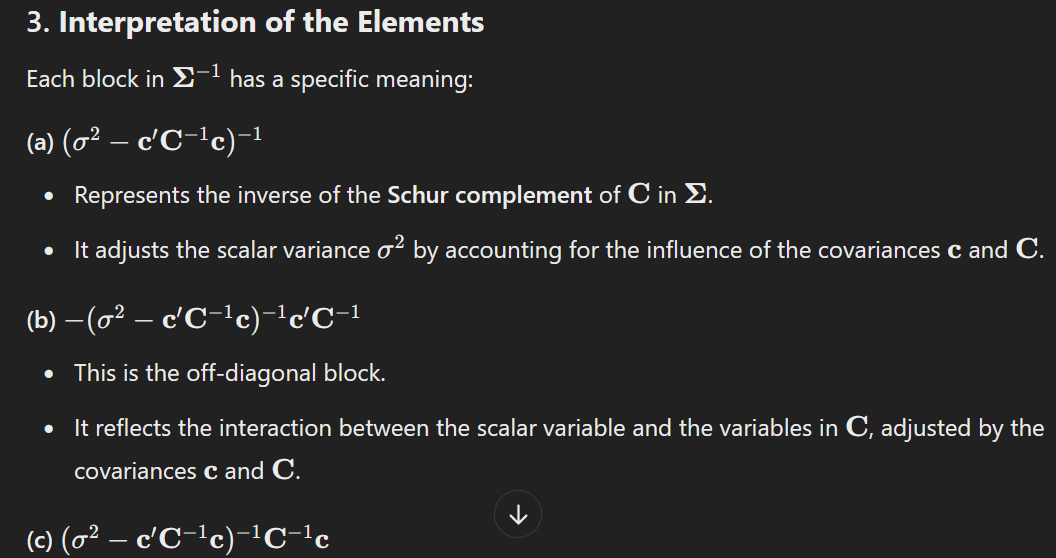
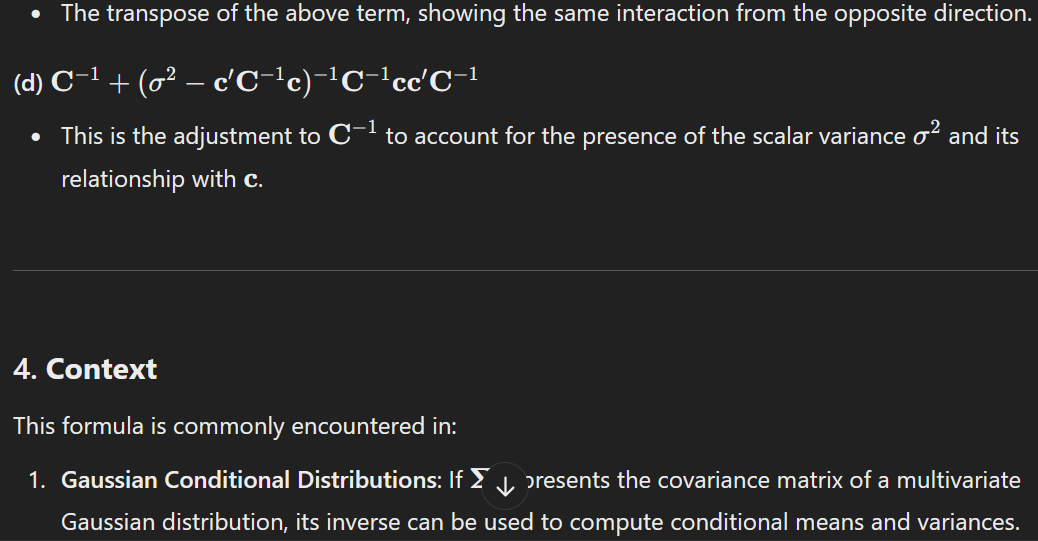
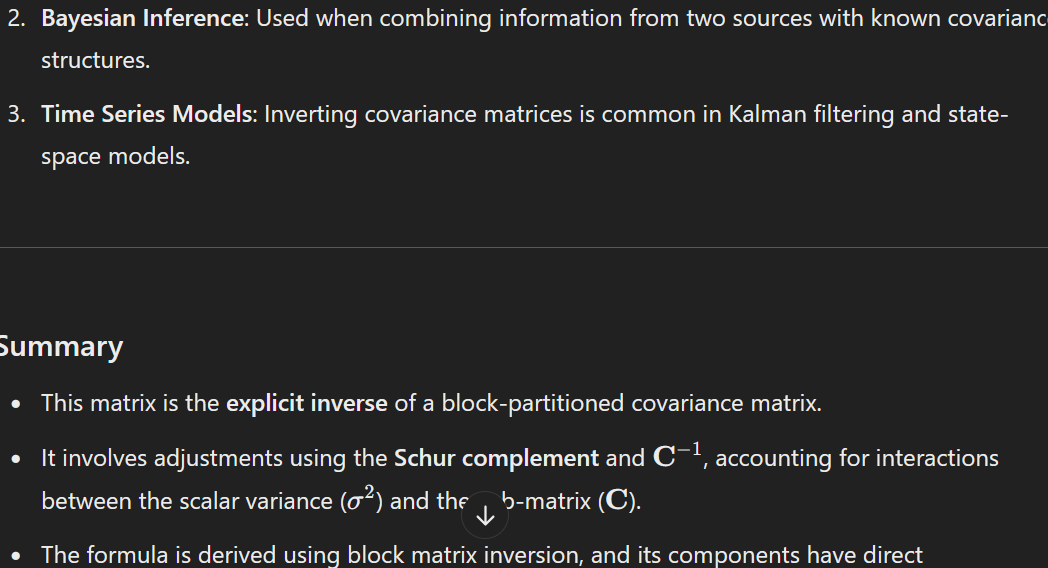
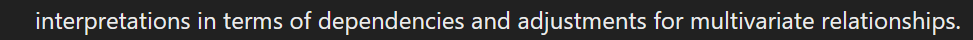

In [70]:
t_oos = returns.index[returns.index > separation_date].values # Out-of-sample data 
Tt = len(t_oos) # Nb of dates
nb_port = 3 # Nb of portfolios/strats
port_weights = {} # Initial portf. weights in dict
port_returns = {} # Initial portf. returns in dict


In [103]:
def weights_sparsehedge(returns, alpha, Lambda):
        weights = [] # Initiate weights in list
        lr = ElasticNet(alpha=alpha,l1_ratio=Lambda) # ?? elasticnet
        for col in returns.columns: # Loop on the assets
            y = returns[col].values # Dependent variable
            X = returns.drop(col, axis=1).values # Independent variable
            lr.fit(X,y)
            err = y - lr.predict(X) # Prediction errors
            w = (1-np.sum(lr.coef_))/np.var(err) # Output: weight of asset i
            weights.append(w)
        return weights / np.sum(weights) # Normalisation of weights

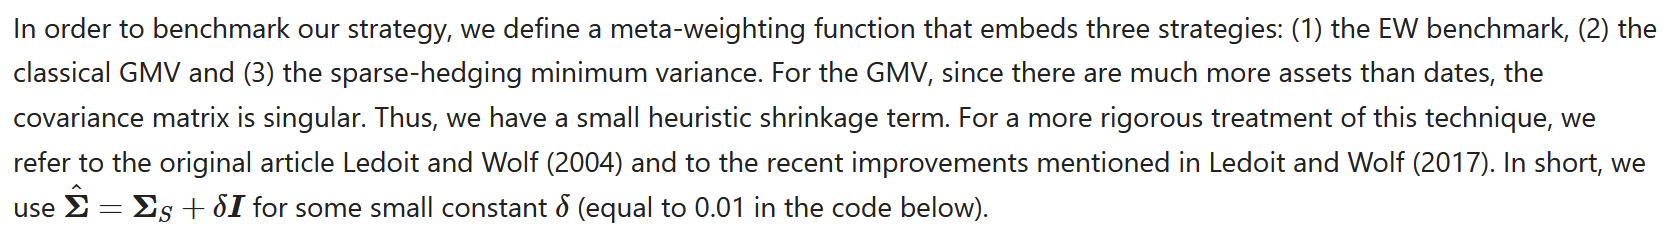

In [104]:
def weights_multi(returns, j, alpha, Lambda):
    N = returns.shape[1]
    if j == 0: # j = 0 => EW
        return np.repeat(1/N,N) 
    elif j == 1: # j = 1 => Minimum Variance
        sigma = np.cov(returns.T) + 1e-2 * np.identity(N) # Covariance matrix + regularizing term
        w = np.matmul(np.linalg.inv(sigma),np.repeat(1,N)) # Multiply & inverse
        return w / np.sum(w) # Normalize
    elif j == 2: # j = 2 => Penalised / elasticnet
        return weights_sparsehedge(returns, alpha, Lambda)

In [107]:
a = np.array([[1, 2], [3, 4]])
for index, x in np.ndenumerate(a):
    print(index, x)

(0, 0) 1
(0, 1) 2
(1, 0) 3
(1, 1) 4


In [79]:
for m, month in np.ndenumerate(t_oos): # Loop = rebal.dates
        temp_data = returns.loc[returns.index < month] # Data for weights
        realised_returns = returns.loc[returns.index == month].values # OOS returns
        weights_temp = {} 
        returns_temp = {}

        for j in range(nb_port): # Loop over strats
            wgts = weights_multi(temp_data, j, 0.1, 0.1) # Hard-coded params!
            rets = np.sum(wgts * realised_returns) # Portf. returns
            weights_temp[j] = wgts
            returns_temp[j] = rets

            port_weights[month] = weights_temp # not used but created
            port_returns[month] = returns_temp


In [80]:
port_returns_final = pd.concat(
        {k: pd.DataFrame.from_dict(v, 'index') for k, v in port_returns.items()}, 
        axis=0).reset_index() # Dict comprehension approach -- https://www.python.org/dev/peps/pep-0274/

colnames = ['date','strategy','return'] # Colnames
port_returns_final.columns = colnames # Colnames
strategies_name = {0:'EW',1:'MV',2:'Sparse'}
port_returns_final['strategy'] = port_returns_final['strategy'].replace(strategies_name)
pd.DataFrame(port_returns_final.groupby('strategy')['return'].std()).T # Portfolio volatilities (monthly scale)


strategy,EW,MV,Sparse
return,0.041804,0.033504,0.034882


In [110]:
import os
os.getcwd()

'C:\\Users\\avi\\Possible_Project\\FactorInvesting'